# Data science analysis: ttH(bb) dilepton channel

**Notebook by Christian Contreras-Campana, PhD**

## Introduction

Developing a data analytic report scheme for ttH(bb) multivariate analysis study using machine larning technologies.

The columns in the file are:
- mass_tag_tag_min_deltaR: Mass for b-tag jet pair with minimum $\Delta$R
- median_mass_jet_jet: Median invariant mass of all combinations of jet pairs
- maxDeltaEta_tag_tag:  The $\Delta\eta$ between the two furthest b-tagged jets
- mass_higgsLikeDijet:  The invariant mass of a jet pair ordered in closeness to a Higgs mass
- HT_tags: Scalar sum of transverse momentum for all jets
- btagDiscriminatorAverage_tagged:  Average CSV b-tag discriminant value for b-tagged jets
- mass_jet_tag_min_deltaR:  Invariant mass of jet pair (with at least one b-tagged) $\Delta$R
- mass_jet_jet_min_deltaR:  Invariant mass of jet pair $\Delta$R
- mass_tag_tag_max_mass:  Mass for b-tagged jet pair with maximum invariant mass combination
- centrality_jets_leps:  The ratio of the sum of the transverse momentum of all jets and leptons
- maxDeltaEta_jet_jet:  Invariant mass of jet pair $\Delta$R
- centrality_tags:  The ratio of the sum of the transverse momentum of all b-tagged jets

While we have some grasp on the matter, we're not experts, so the following might contain inaccuracies or even outright errors. Feel free to point them out, either in the comments or privately.

## Load Libraries

We load all the necessary python libraries that will permit us to load the data files, pre-process and clean the data, perform data validation, produce statistical summaries, conduct exploratory data analysis, as well as feature transformation, feature ranking, and feature selection. Python libraries will also be needed for model selection, evaluating overfitting, executing standard nested k-fold cross validation for hyper-parameter optimization and model evaluation.  

In [12]:
## Import common python libraries
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import from root_numpy library
import root_numpy
from root_numpy import root2array, rec2array

# Import panda library
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index
import pandas.core.common as com

# Import scipy
import scipy
from scipy.stats import ks_2samp
import scipy as sp

# Import itertools
import itertools
from itertools import cycle

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell

# Import scikit-learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFECV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve)
from sklearn.dummy import DummyClassifier

from sklearn.externals import joblib
from sklearn import feature_selection

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import defaultdict, Counter

import re

# Check the versions of libraries/packages
print("Python version " + sys.version)
print("Sklearn version " + sklearn.__version__)
print("Root_numpy version " + root_numpy.__version__)
print("Numpy version " + np.__version__)
print("Scipy version " + scipy.__version__)
print("Pandas version " + pd.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Seaborn version " + sns.__version__)
print("Imblance version " +imblearn.__version__)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Specifying which nodes should be run interactively
InteractiveShell.ast_node_interactivity = "all"
print(__doc__)

Python version 2.7.13 (v2.7.13:a06454b1afa1, Dec 17 2016, 12:39:47) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Sklearn version 0.18.1
Root_numpy version 4.7.2
Numpy version 1.12.0
Scipy version 0.18.1
Pandas version 0.19.0+515.gd0a281f
Matplotlib version 2.0.0
Seaborn version 0.8.dev
Imblance version 0.2.1
Automatically created module for IPython interactive environment


## Load Data Files

Most data files contain approximately 15K events. There are a total of 4 files totaling 80K data events. We list the features and response names. We store the data in a Pandas DataFrame for greater ease of data manipulation.

**Note: To reduce running time of the program we use our most signal-like category which is statistically limited**

In [13]:
## Define data load function

def load(sig_filename, bkg_filename, category, features):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    sig_filename : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    bkg_filename : array, shape = [n_samples, n_classes]
    category: string
    features: array, shape = [n_features]

    Returns
    -------
    data : pandas.DataFrame
    """

    signal = root2array(sig_filename, category, features)
    signal = rec2array(signal)

    backgr = root2array(bkg_filename, category, features)
    backgr = rec2array(backgr)

    # for sklearn data is usually organised
    # into one 2D array of shape (n_samples x n_features)
    # containing all the data and one array of categories
    # of length n_samples
    X = np.concatenate((signal, backgr))
    y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

    # convert to numpy ndarray into pandas dataframe
    dataframe_X = pd.DataFrame(data=X, columns=features)
    dataframe_y = pd.DataFrame(data=y, columns=['y'])

    data = pd.concat([dataframe_X, dataframe_y], axis=1)

    return data

In [14]:
## Load data files

# Feature names
branch_names = """mass_tag_tag_min_deltaR,median_mass_jet_jet,
    maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,
    btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,
    mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,
    centrality_jets_leps,centrality_tags""".split(",")

features = [c.strip() for c in branch_names]
features = (b.replace(" ", "_") for b in features)
features = list(b.replace("-", "_") for b in features)

wall = time.time()
process = time.clock()

# Load dataset
signal_sample = "combined/signalMC.root"
background_sample = "combined/backgroundMC.root"
tree_category = "event_mvaVariables_step7_cate4"

data = load(signal_sample, background_sample, tree_category, features)

print "Total number of events: {}\nNumber of features: {}".format(data.shape[0], data.shape[1])

# Store a copy for later use
df_archived = data.copy(deep=True)

print "\nWall time to read in file input: ", time.time()-wall
print "Elapsed time to read in file input: ", time.clock()-process

Total number of events: 11502
Number of features: 13

Wall time to read in file input:  0.676692008972
Elapsed time to read in file input:  0.33882


In [15]:
## Define class label counts and percentages

def class_info(classes):
    # Store the number of signal and background events
    class_count = {}
    counts = Counter(classes)
    total = sum(counts.values())

    for cls in counts.keys():
        class_count[class_label[cls]] = counts[cls]
        print("%6s: % 7d  =  % 5.1f%%" % (class_label[cls], counts[cls], float(counts[cls])/float((total))*100.0))

    return (class_count["signal"], class_count["background"])

In [16]:
# Determine class label counts and percentages
class_label = {0.0: "background", 1.0: "signal"}
class_info(data.y);

background:    6777  =   58.9%
signal:    4725  =   41.1%


In [17]:
## Create features dataframe and target array

df_X = data.drop("y", axis=1, inplace=False)
df_y = data["y"]

## Statistical Summary

We give a statistical summary below to make sure the data makes sense and that nothing anomolous is present. As we can see values look promising and have acceptable variances.

In [18]:
## Print statistical summary of dataset

# To print out all rows and columns to the terminal
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

wall = time.time()
process = time.clock()

print "Head:"
data.head()

print "Describe:"
data.describe()

print "Information:" 
data.info()


print "\nWall time to print statistical summary: ", time.time()-wall
print "Elapsed time to print statistical summary: ", time.clock()-process

Head:


mass_tag_tag_min_deltaR  median_mass_jet_jet  maxDeltaEta_tag_tag  \
0               147.846252           132.468857             0.687603   
1               108.483505            77.382843             0.864248   
2               105.684814           105.684814             1.058237   
3                95.740837           159.740494             1.064351   
4                46.943771           102.658394             0.745558   

   mass_higgsLikeDijet     HT_tags  btagDiscriminatorAverage_tagged  \
0           121.850945  541.808899                         0.930030   
1           135.828598  337.069611                         0.950204   
2           119.816292  315.525421                         0.982161   
3           123.214333  793.738770                         0.947199   
4           109.506470  341.026093                         0.937956   

   mass_jet_tag_min_deltaR  mass_jet_jet_min_deltaR  mass_tag_tag_max_mass  \
0                70.543983                70.543983             346.367706   
1                41.899509                41.899509             108.483505   
2               105.684814               105.684814             179.085861   
3                95.740837                95.740837             394.918854   
4                46.943771                46.943771             199.907959   

   maxDeltaEta_jet_jet  centrality_jets_leps  centrality_tags    y  
0             3.860818              0.428497         0.497305  1.0  
1             3.070951              0.622126         0.816453  1.0  
2             3.676557              0.558623         0.811920  1.0  
3             1.817336              0.772420         0.925377  1.0  
4             1.285695              0.900433         0.971768  1.0

Describe:


mass_tag_tag_min_deltaR  median_mass_jet_jet  maxDeltaEta_tag_tag  \
count             11502.000000         11502.000000         11502.000000   
mean                 72.794937           130.884079             1.999546   
std                  44.363853            53.103275             0.853363   
min                  12.633512            34.977924             0.056909   
25%                  41.649353            95.079142             1.353945   
50%                  61.460218           119.805786             1.916782   
75%                  94.571838           153.676071             2.571373   
max                 940.192627           599.893066             4.743262   

       mass_higgsLikeDijet       HT_tags  btagDiscriminatorAverage_tagged  \
count         11502.000000  11502.000000                     11502.000000   
mean            123.582291    330.700500                         0.953733   
std              12.654324    148.160446                         0.022884   
min              31.166857    106.436119                         0.862530   
25%             118.288080    230.768669                         0.938434   
50%             124.319786    296.221405                         0.955591   
75%             129.130924    388.999527                         0.970816   
max             282.346588   2481.391113                         0.998742   

       mass_jet_tag_min_deltaR  mass_jet_jet_min_deltaR  \
count             11502.000000             11502.000000   
mean                 59.162647                57.746330   
std                  34.898560                34.171822   
min                  12.552081                12.552081   
25%                  34.224159                33.378013   
50%                  49.430418                48.307941   
75%                  73.925880                72.215767   
max                 348.198029               348.198029   

       mass_tag_tag_max_mass  maxDeltaEta_jet_jet  centrality_jets_leps  \
count           11502.000000         11502.000000          11502.000000   
mean              277.902466             2.555769              0.611077   
std               166.944412             0.935243              0.140324   
min                44.503445             0.056909              0.238576   
25%               167.251320             1.849569              0.505054   
50%               233.957787             2.543590              0.608996   
75%               336.919250             3.238992              0.715097   
max              2664.628906             4.773415              0.966779   

       centrality_tags             y  
count     11502.000000  11502.000000  
mean          0.644550      0.410798  
std           0.165861      0.492000  
min           0.220871      0.000000  
25%           0.516360      0.000000  
50%           0.652510      0.000000  
75%           0.776901      1.000000  
max           0.989593      1.000000

Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11502 entries, 0 to 11501
Data columns (total 13 columns):
mass_tag_tag_min_deltaR            11502 non-null float32
median_mass_jet_jet                11502 non-null float32
maxDeltaEta_tag_tag                11502 non-null float32
mass_higgsLikeDijet                11502 non-null float32
HT_tags                            11502 non-null float32
btagDiscriminatorAverage_tagged    11502 non-null float32
mass_jet_tag_min_deltaR            11502 non-null float32
mass_jet_jet_min_deltaR            11502 non-null float32
mass_tag_tag_max_mass              11502 non-null float32
maxDeltaEta_jet_jet                11502 non-null float32
centrality_jets_leps               11502 non-null float32
centrality_tags                    11502 non-null float32
y                                  11502 non-null float64
dtypes: float32(12), float64(1)
memory usage: 629.1 KB

Wall time to print statistical summary:  0.115341901779
Elapsed time

## Feature Visualization: Basic Exploratory Data Analysis¶
We conduct a basic exploratory data analyses by producing correlaiton matrices between all variables of interest. In addition, we visually depict the relationship signal and background rate and feature variables.

In [19]:
## Plot signal and background distributions for some variables

# The first two arguments select what is "signal"
# and what is "background". This means you can
# use it for more general comparisons of two
# subsets as well.

def signal_background(data1, data2, column=None, grid=True,
                      xlabelsize=None, xrot=None, ylabelsize=None,
                      yrot=None, ax=None, sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=10, **kwds):
   """Draw histogram of the DataFrame's series comparing the distribution
   in `data1` to `data2`.

   data1: DataFrame
   data2: DataFrame
   column: string or sequence
       If passed, will be used to limit data to a subset of columns
   grid : boolean, default True
       Whether to show axis grid lines
   xlabelsize : int, default None
       If specified changes the x-axis label size
   xrot : float, default None
       rotation of x axis labels
   ylabelsize : int, default None
       If specified changes the y-axis label size
   yrot : float, default None
       rotation of y axis labels
   ax : matplotlib axes object, default None
   sharex : bool, if True, the X axis will be shared amongst all subplots.
   sharey : bool, if True, the Y axis will be shared amongst all subplots.
   figsize : tuple
       The size of the figure to create in inches by default
   layout: (optional) a tuple (rows, columns) for the layout of the histograms
   bins: integer, default 10
       Number of histogram bins to be used
   kwds : other plotting keyword arguments
       To be passed to hist function
   """        

   if "alpha" not in kwds:
       kwds["alpha"] = 0.5

   w, h = (12, 8)
   figsize = (w, h)

   if column is not None:
       if not isinstance(column, (list, np.ndarray, Index)):
           column = [column]
       data1 = data1[column]
       data2 = data2[column]

   data1 = data1._get_numeric_data()
   data2 = data2._get_numeric_data()
   naxes = len(data1.columns)


   fig, axes = plotting._subplots(naxes=naxes, 
                                  ax=ax, 
                                  squeeze=False,
                                  sharex=sharex,
                                  sharey=sharey,
                                  figsize=figsize,
                                  layout=layout)
   xs = plotting._flatten(axes)

   for i, col in enumerate(com._try_sort(data1.columns)):
       ax = xs[i]
       low = min(data1[col].min(), data2[col].min())
       high = max(data1[col].max(), data2[col].max())
       ax.hist(data1[col].dropna().values,
               bins=bins, histtype='stepfilled', range=(low,high), **kwds)
       ax.hist(data2[col].dropna().values,
               bins=bins, histtype='stepfilled', range=(low,high), **kwds)
       ax.set_title(col)
       ax.legend(['background', 'signal'], loc='best')
       ax.set_facecolor('white')
    
       # Customize the major grid
       ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
       ax.set_facecolor('white')
    

   plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
                             ylabelsize=ylabelsize, yrot=yrot)
   fig.subplots_adjust(wspace=0.5, hspace=0.8)

   return plt.show()

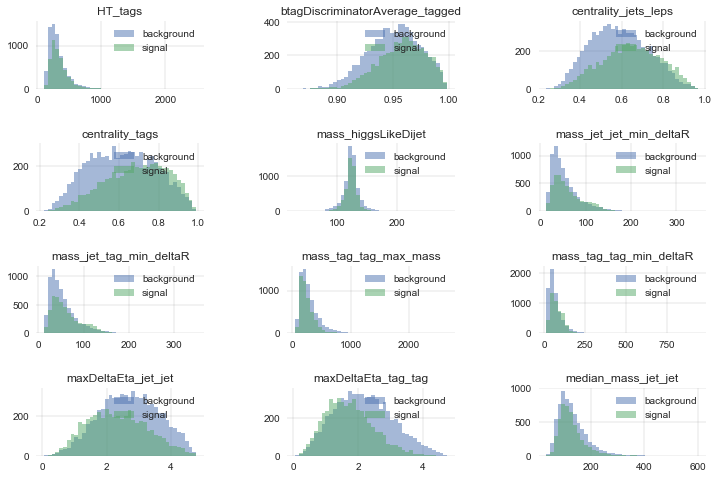


Wall time to plot exploratory data features:  2.01082086563
Elapsed time to plot exploratory data features:  1.896864


In [20]:
## Plot feature hitograms

wall = time.time()
process = time.clock()

signal_background(data[data["y"] < 0.5], data[data["y"] > 0.5],
                  column=features, bins=40);

print "\nWall time to plot exploratory data features: ", time.time()-wall
print "Elapsed time to plot exploratory data features: ", time.clock()-process

In [21]:
## Define linear correlation matrix

def correlations(data, **kwds):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    data : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    kwds : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
        
    
    """To calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    
    # Select signal or background label for plot title
    if (data["y"] > 0.5).all(axis=0):
        label = "signal"
    elif (data["y"] < 0.5).all(axis=0):
        label = "background"
    
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    data = data.drop("y", axis=1) 
 
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    labels = data.corr(**kwds).columns.values
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(8,7))
    
    opts = {"annot" : True,
            "ax" : ax1,
            "vmin": 0, "vmax": 1*100,
            "annot_kws" : {"size": 8}, 
            "cmap": plt.get_cmap("Blues", 20),
            }
    
    ax1.set_title("Correlations: " + label)

    sns.heatmap(data.corr(method="spearman").iloc[::-1]*100, **opts) 
    
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels[::-1], minor=False, ha="right", rotation=70)
        ax.set_yticklabels(np.flipud(labels), minor=False)
        
    plt.tight_layout()
    
    return plt.show()

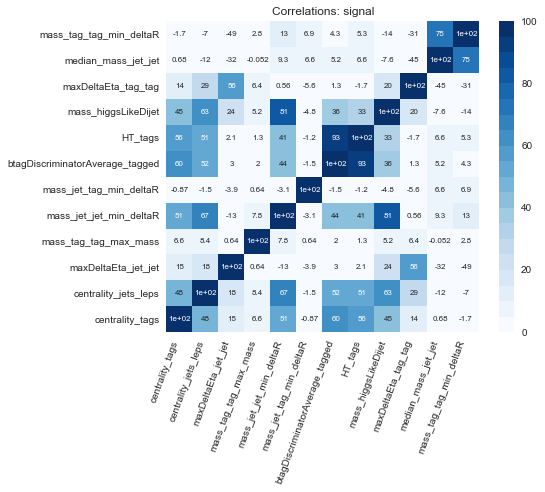

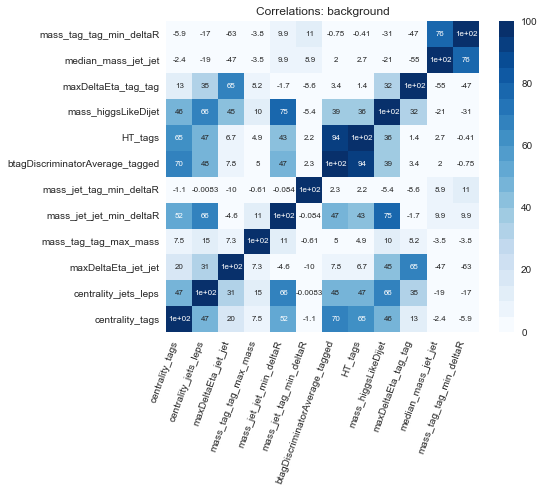

Wall time to plot correlation matrix:  2.46683692932
Elapsed time to plot correlation matrix:  2.313998


In [22]:
## Plot feature correlations (assuming linear correlations)

wall = time.time()
process = time.clock()

# Remove the y column from the correlation matrix
# after using it to select background and signal
sig = data[data["y"] > 0.5]
bg = data[data["y"] < 0.5]

# Correlation Matrix
correlations(sig)
correlations(bg)

print "Wall time to plot correlation matrix: ", time.time()-wall
print "Elapsed time to plot correlation matrix: ", time.clock()-process

Wall time to plot scatter distribution:  33.3047168255
Elapsed time to plot scatter distribution:  31.839715


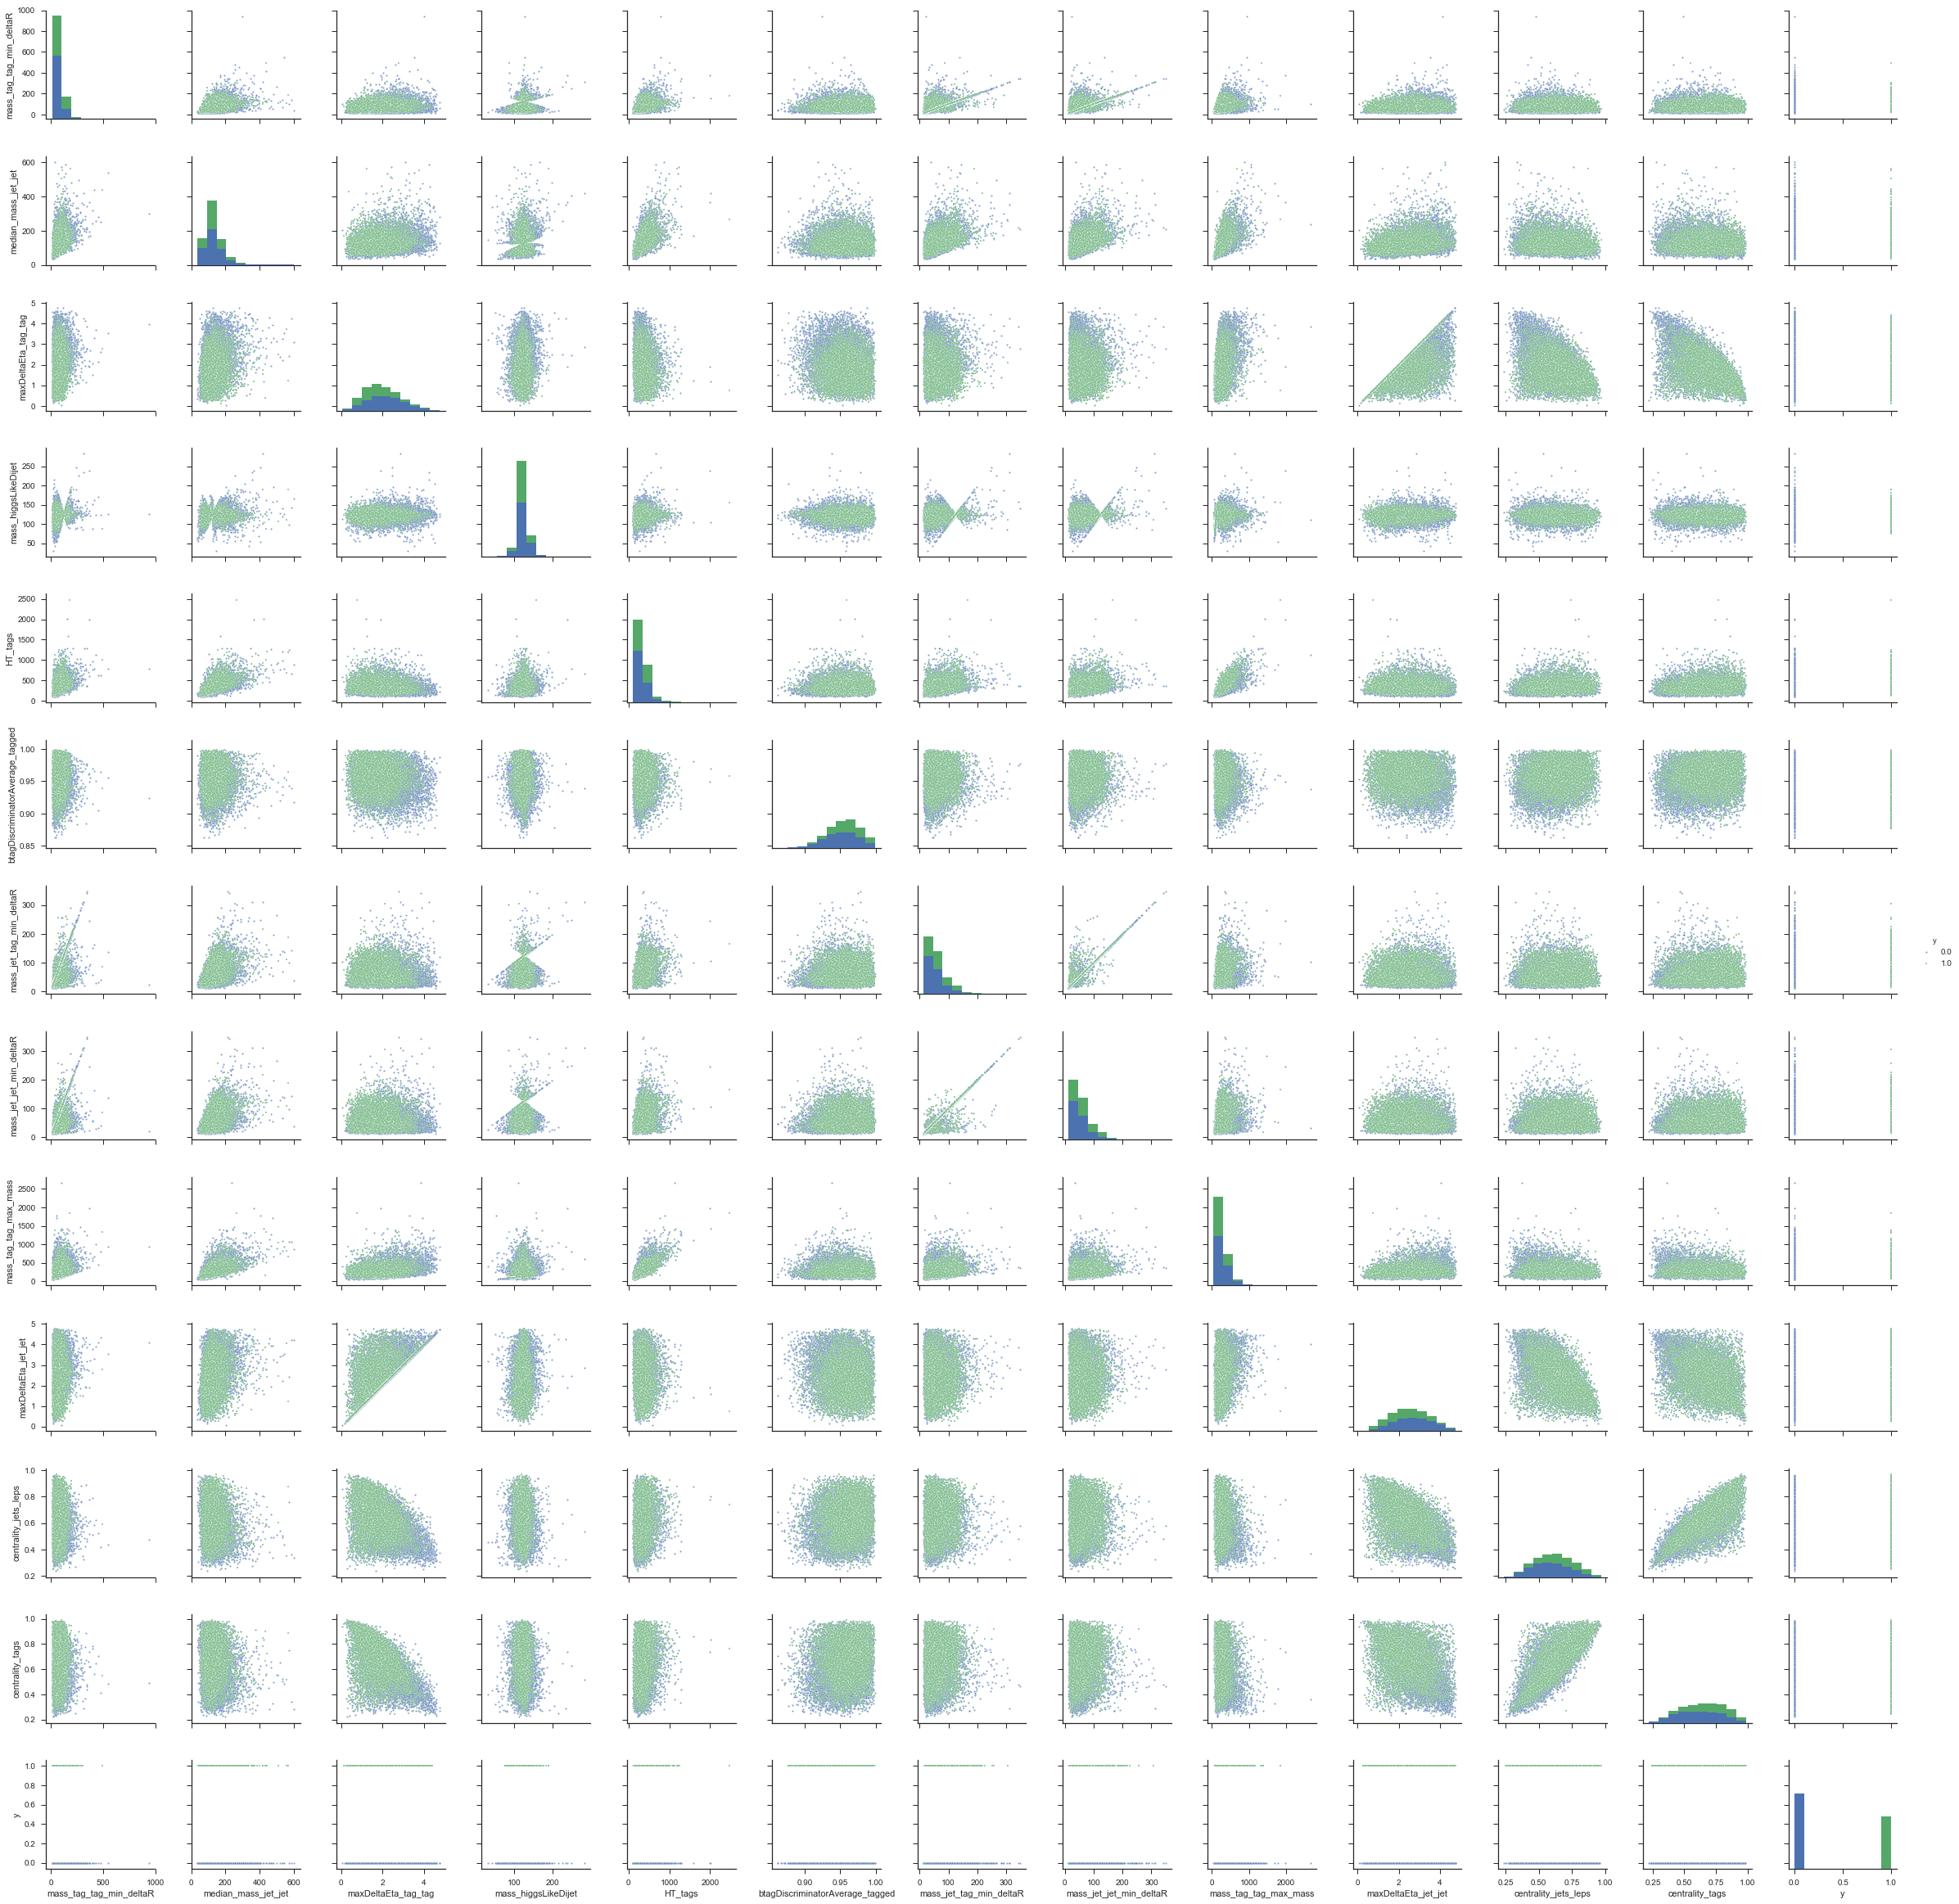

In [23]:
## Scatter Plot
%matplotlib inline

sns.set(style="ticks", color_codes=True)
wall = time.time()
process = time.clock()

random.seed(a=seed)

#_ = sns.pairplot(data.drop(data.y, axis=0), size=2.5, hue="y")
_ = sns.pairplot(data.drop(data.y, axis=0), size=2.5, hue="y", 
                 markers=["o", "s"], plot_kws={ "s":5,"alpha":0.7 })
#sns.plt.show()

print "Wall time to plot scatter distribution: ", time.time()-wall
print "Elapsed time to plot scatter distribution: ", time.clock()-process

## Model performance measure

We investigate several machine learning models in order to establish which algorithm may be the most promising for the discrimination modeling of signal and background processes. Two performance measures wil be used to help select our model, namely, accuracy and the area under the receiver operating characteristic (ROC) curve. Receiver Operating Characteristic (ROC) curve number is equal to the probability that a random positive example will be ranked above a random negative example.

In [24]:
## Compute ROC curve and area under the curve

def roc_plot(models, X, y, n_folds=3):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    models : dictionary, shape = [n_models]
    X : DataFrame, shape = [n_samples, n_classes]
    y : DataFrame, shape = [n_classes]

    Returns
    -------
    roc : matplotlib plot
    """
     
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
                                                        test_size=0.33, random_state=seed)
    
    # contains rates for ML classifiers
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    # Include random by chance 'luck' curve
    plt.plot([1, 0], [0, 1], '--', color=(0.1, 0.1, 0.1), label='Luck')
        
    # Loop through classifiers
    for (name, model) in models.items():
        
        print "\n\x1b[1;31mBuilding model ...\x1b[0m"
        process = time.clock()
        model.fit(X_train, y_train)
        print "\t%s fit time: %.3f"%(name, time.clock()-process)
        
        y_predicted = model.predict(X_test)
        
        process = time.clock()
        print classification_report(y_test, y_predicted, target_names=['signal', 'background'])
        print("\tScore (i.e. accuracy) of test dataset: {:.5f}".format(model.score(X_test, y_test)))
        scores = cross_val_score(model, X_test, y_test, scoring="roc_auc",
                                 n_jobs=1, cv=n_folds) #n_jobs=-1
        print "\tCross-validated AUC ROC accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())  
        print "\tCross-validation time: ", time.clock()-process
        
        if hasattr(model, "predict_proba"):
            # probability estimates of the positive class(as needed in the roc_curve function)
            decisions = model.predict_proba(X_test)[:, 1]
        else:  # use decision function
            decisions = model.decision_function(X_test)
        
        process = time.clock()
        fpr[name], tpr[name], thresholds = roc_curve(y_test, decisions)
        
        roc_auc[name] = auc(fpr[name], tpr[name])
        print "\tAUC ROC score for %s: %.4f"%(name, roc_auc[name])
        print "\tAUC ROC time: ", time.clock()-process
    
    # color choices: https://css-tricks.com/snippets/css/named-colors-and-hex-equivalents/
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 
                    'green', 'yellow', 'SlateBlue', 'DarkSlateGrey',
                    'CadetBlue', 'Chocolate', 'darkred', 'GoldenRod'])
  
    for (name, model), color in zip(models.items(), colors):

        signal_efficiecy = tpr[name] # true positive rate (tpr)
        background_efficiecy = fpr[name] # false positive rate (fpr)
        # NOTE: background rejection rate = 1 - background efficiency (i.e specicity)
        background_rejection_rate = 1 - background_efficiecy
        
        plt.plot(signal_efficiecy, background_rejection_rate, color=color, lw=2,
                 label='%s (AUC = %0.3f)'%(name, roc_auc[name]))                 
    
    # Plot all ROC curves
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Signal Efficiency (True Positive Rate)')
    plt.ylabel('Background Rejection Rate (1- False Positive Rate)')
    plt.title("Receiver operating characteristic ({} events)".format(X.shape[0]))
    leg = plt.legend(loc="lower left", frameon=True, fancybox=True, fontsize=8) # loc='best'
    leg.get_frame().set_edgecolor('w')
    frame = leg.get_frame()
    frame.set_facecolor('White')
    
    return plt.show()


Building model ...
	KNN fit time: 0.011
             precision    recall  f1-score   support

     signal       0.69      0.71      0.70      1513
 background       0.56      0.54      0.55      1030

avg / total       0.64      0.64      0.64      2543

	Score (i.e. accuracy) of test dataset: 0.64294
	Cross-validated AUC ROC accuracy: 0.66386 (+/- 0.01995)
	Cross-validation time:  0.361968
	AUC ROC score for KNN: 0.6648
	AUC ROC time:  0.000800999999996

Building model ...
	SVM fit time: 1.764
             precision    recall  f1-score   support

     signal       0.76      0.66      0.71      1513
 background       0.58      0.70      0.64      1030

avg / total       0.69      0.68      0.68      2543

	Score (i.e. accuracy) of test dataset: 0.67519
	Cross-validated AUC ROC accuracy: 0.73617 (+/- 0.00871)
	Cross-validation time:  0.797523
	AUC ROC score for SVM: 0.7426
	AUC ROC time:  0.00203400000001

Building model ...
	CART fit time: 0.081
             precision    recall  f1-sc

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


	Cross-validated AUC ROC accuracy: 0.72914 (+/- 0.00466)
	Cross-validation time:  4.732478
	AUC ROC score for MLP: 0.7467
	AUC ROC time:  0.001054

Building model ...
	ADA fit time: 0.641
             precision    recall  f1-score   support

     signal       0.72      0.75      0.74      1513
 background       0.61      0.58      0.59      1030

avg / total       0.68      0.68      0.68      2543

	Score (i.e. accuracy) of test dataset: 0.67951
	Cross-validated AUC ROC accuracy: 0.72193 (+/- 0.00610)
	Cross-validation time:  0.864694
	AUC ROC score for ADA: 0.7315
	AUC ROC time:  0.00112800000001

Building model ...
	LDA fit time: 0.011
             precision    recall  f1-score   support

     signal       0.68      0.79      0.73      1513
 background       0.60      0.46      0.52      1030

avg / total       0.65      0.66      0.65      2543

	Score (i.e. accuracy) of test dataset: 0.65592
	Cross-validated AUC ROC accuracy: 0.70727 (+/- 0.00998)
	Cross-validation time:  0.03195


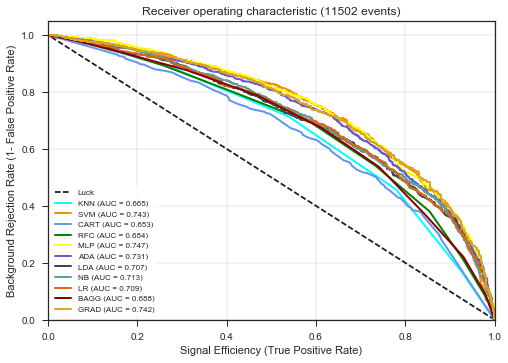


Wall time to generate ROC plots:  17.5809600353
Elapsed time to generate ROC plots:  16.453633


In [29]:
# Plot AUC for ROC curve for several classifiers out-of-the-box

wall = time.time()
process = time.clock()

# Set feature scaling type
scaler = RobustScaler()

# NOTE: When using scikit-learn's DecisionTreeClassifier, 
# always set min_samples_leaf to something like 5 or 10. 
# Its default value of 1 is useless and is guaranteed to overfit. 
# (This is why every example of DecisionTreeClassifier in their docs shows overfitting.)

# prepare models: create a mapping of ML classifier name to algorithm
pipe_classifiers = {
    'SVM':  make_pipeline(scaler, SVC(class_weight="balanced")),
    'NB' :  make_pipeline(scaler, GaussianNB()), 
    'MLP':  make_pipeline(scaler, MLPClassifier()),
    'LR' :  make_pipeline(scaler, LogisticRegression(class_weight="balanced")),
    'ADA':  make_pipeline(None,   AdaBoostClassifier()),
    'KNN':  make_pipeline(scaler, KNeighborsClassifier()),
    'RFC':  make_pipeline(None,   RandomForestClassifier()),
    'CART': make_pipeline(None,   DecisionTreeClassifier(min_samples_leaf=10,
                                                        class_weight="balanced")),
    'LDA':  make_pipeline(scaler, LinearDiscriminantAnalysis()),
    'GRAD': make_pipeline(None,   GradientBoostingClassifier()),
    'BAGG': make_pipeline(None,   BaggingClassifier())
}

# Assessing a Classifier's Performance
roc_plot(pipe_classifiers, df_X, df_y)

# Generally speaking non-cross-validated AUC ROC version is slight optmistic 
# compared to cv-version by ~1-2% because the data composition between signal and data is balanced.
# Note: Useclass balancing for thos classifier that can apply it, shows about 2% improvement
print "\nWall time to generate ROC plots: ", time.time()-wall
print "Elapsed time to generate ROC plots: ", time.clock()-process

## Precision-Recall Plots

Precision-Recall metric to evaluate classifier output quality.

Recall is a performance measure of the whole positive part of a dataset, whereas precision is a performance measure of positive predictions.

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

It is important to note that the precision may not decrease with recall. The definition of precision ($\frac{T_p}{T_p + F_p}$) shows that lowering the threshold of a classifier may increase the denominator, by increasing the number of results returned. If the threshold was previously set too high, the new results may all be true positives, which will increase precision. If the previous threshold was about right or too low, further lowering the threshold will introduce false positives, decreasing precision.

Recall is defined as $\frac{T_p}{T_p+F_n}$, where $T_p+F_n$ does not depend on the classifier threshold. This means that lowering the classifier threshold may increase recall, by increasing the number of true positive results. It is also possible that lowering the threshold may leave recall unchanged, while the precision fluctuates.

SOURCE: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

"it has been shown by Davis & Goadrich that an algorithm that optimizes the area under the ROC curve is not guaranteed to optimize the area under the PR curve."

In [27]:
## Define precision-recall curve

def plot_PR_curve(classifier, X, y, n_folds=5):
    """
    Plot a basic precision/recall curve.
    """
    
    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    # Calculate the random luck for PR 
    # (above the constant line is a classifier that is well modeled)
    signal_count, background_count = class_info(y)
    ratio = float(signal_count)/float(signal_count + background_count)
    
    # store average precision calculation
    avg_scores = []
    
    # Loop through classifiers
    for (name, model) in classifier.items():
        
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        
        for i, (train, test) in enumerate(skf.split(X,y)):
            model.fit(X[train], y[train])
                   
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(X[test])[:, 1]
            else:  # use decision function
                probas_ = model.decision_function(X[test])
            
            # Compute precision recall curve
            precision, recall, thresholds = precision_recall_curve(y[test],
                                                                   probas_, pos_label=1)
            # Area under the precision-recall curve (AUCPR)
            average_precision = average_precision_score(y[test], probas_)
            avg_scores.append(average_precision)
        
        plt.plot(recall, precision, lw=1, 
                 label='{0} (auc = {1:0.2f})'.format(name,np.mean(avg_scores, axis=0)))
    
    plt.plot([ratio,ratio], '--', color=(0.1, 0.1, 0.1), 
             label='Luck (auc = {0:0.2f})'.format(ratio))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower left")

    return plt.show()

background:    6777  =   58.9%
signal:    4725  =   41.1%


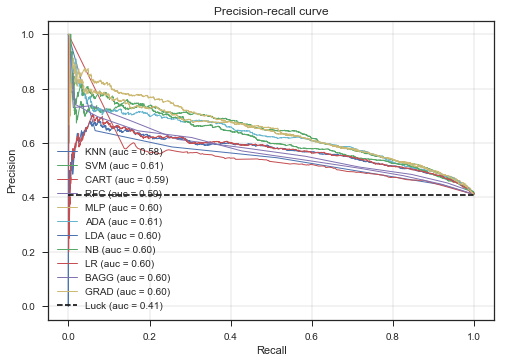


Wall time to generate Precision-Recall plots:  32.1130409241
Elapsed time to generate Precision-Recall plots:  31.740968


In [30]:
# Plot precision-recall curve for several classifiers out-of-the-box

wall = time.time()
process = time.clock()

plot_PR_curve(pipe_classifiers, df_X.values, df_y.values, n_folds=3)

print "\nWall time to generate Precision-Recall plots: ", time.time()-wall
print "Elapsed time to generate Precision-Recall plots: ", time.clock()-process

Among the models with best performance on the test set:

- Random forests
- Gradient boosting 
- Boosting decision tree

We observe that the GradientBoostingClassifier has relatively the best accuracy and area under the ROC curve value. Therefore, we select this predictive model and proceed to evaluate whether it is overfitting the model to the noise (e.g. statistical fluctuation) of the data.

## Overfitting Evaluation

Comparing the ML classifier output distribution for the training and testing set to check for overtraining. By comparing the ML classifier's decision function for each class, as well as overlaying it with the shape of the decision function in the training set.


Using the default parameters for the ML Classifiers we study whether the model is over-fitting the test data.

In [31]:
## Defined overfitting plot

def compare_train_test(clf, X, y, bins=30):
    """Multi class version of Logarithmic Loss metric.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
                                                        test_size=0.33, random_state=seed)
    
    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()
    
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    decisions = []
    for X, y in ((X_train, y_train), (X_test, y_test)):

        if hasattr(clf,"decision_function"):
            d1 = clf.decision_function(X[y>0.5]).ravel()
            d2 = clf.decision_function(X[y<0.5]).ravel()
        else:
            d1 = clf.predict_proba(X[y>0.5])[:, 1]
            d2 = clf.predict_proba(X[y<0.5])[:, 1]
        
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='signal (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='background (train)')
    
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')
    
    # Define signal and background histograms for training & testing 
    hist_sig_train, bins = np.histogram(decisions[0], bins=bins, range=low_high, normed=True)
    hist_bkg_train, bins = np.histogram(decisions[1], bins=bins, range=low_high, normed=True)
    
    hist_sig_test, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    hist_bkg_test, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    
    # Estimate ks-test and p-values as an indicator of overtraining of fit model
    s_ks, s_pv = ks_2samp(hist_sig_train, hist_sig_test)
    b_ks, b_pv = ks_2samp(hist_bkg_train, hist_bkg_test)
    
    if hasattr(clf, "steps"):
        name = clf.steps[1][0]
    else:
        name = clf.__class__.__name__
    
    ax.set_title("Classifier: %s\nsignal(background) ks: %f(%f), p-value: %f (%f)" 
                 % (name, s_ks, b_ks, s_pv, b_pv))

    plt.xlabel("Decision output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    return plt.show()

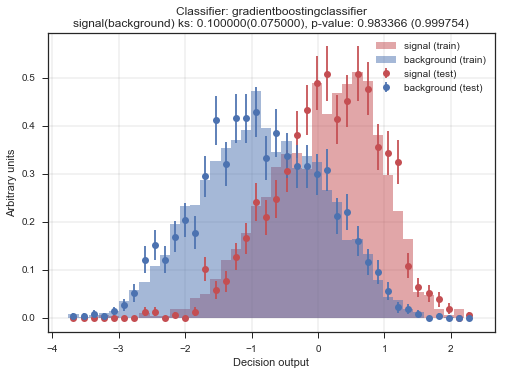

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('nonetype', None), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-0...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))]),
            cv=5, method='sigmoid')

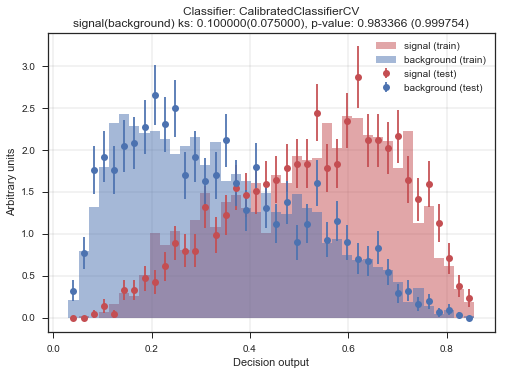

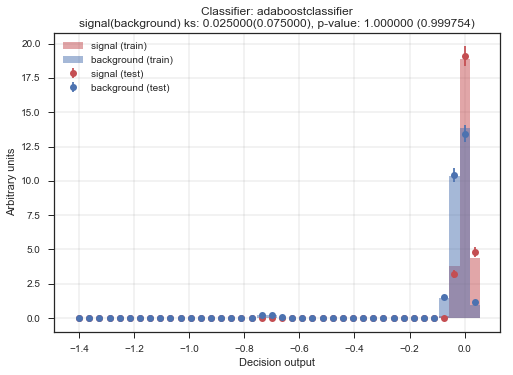

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('nonetype', None), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
            cv=5, method='sigmoid')

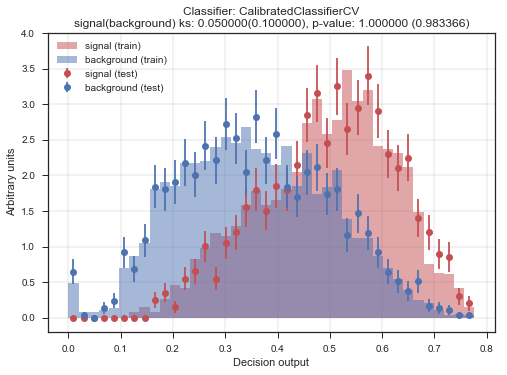

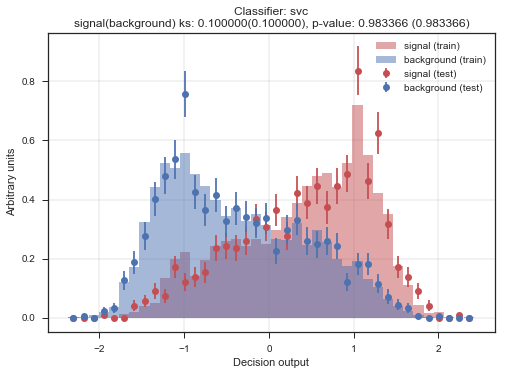

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
            cv=5, method='sigmoid')

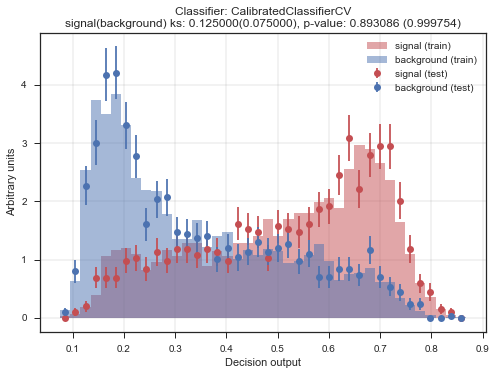

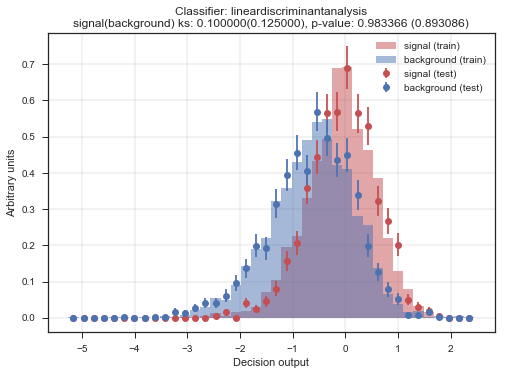

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]),
            cv=5, method='sigmoid')

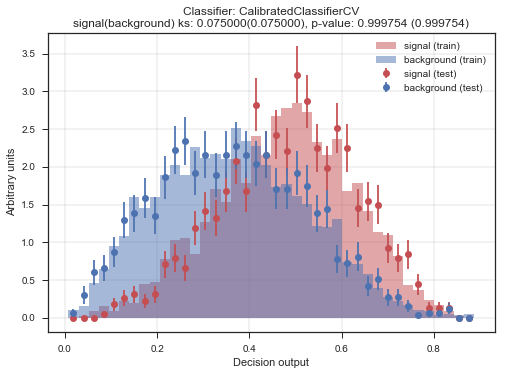

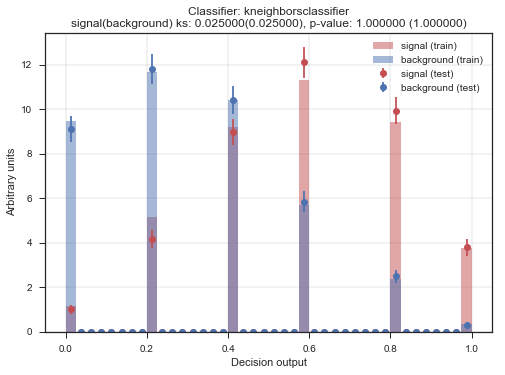

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
            cv=5, method='sigmoid')

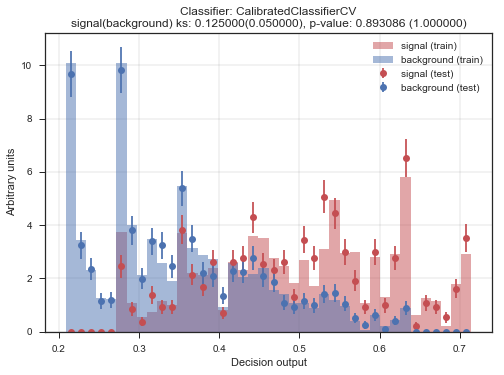

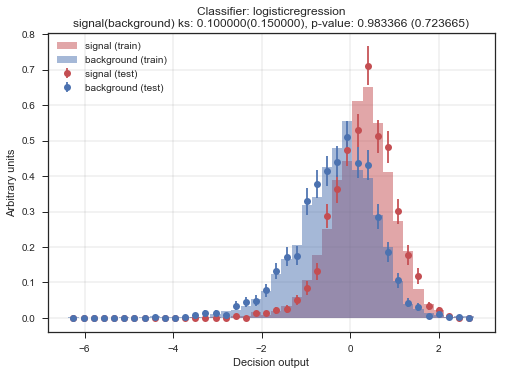

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
            cv=5, method='sigmoid')

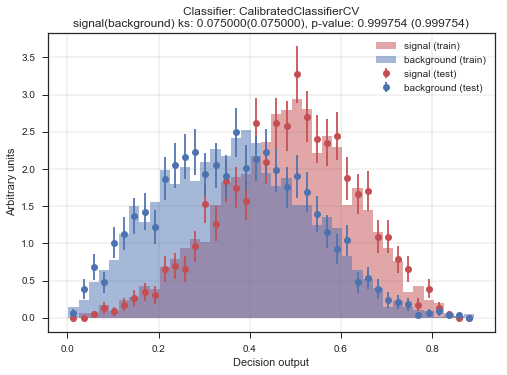

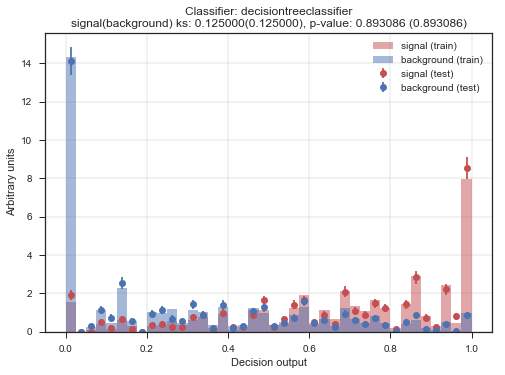

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('nonetype', None), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
            cv=5, method='sigmoid')

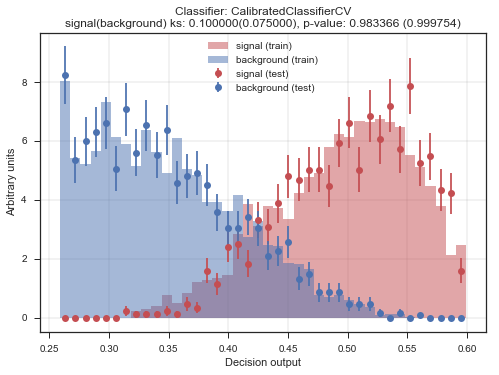

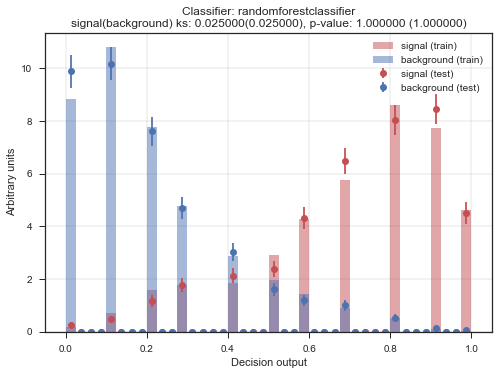

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('nonetype', None), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
            cv=5, method='sigmoid')

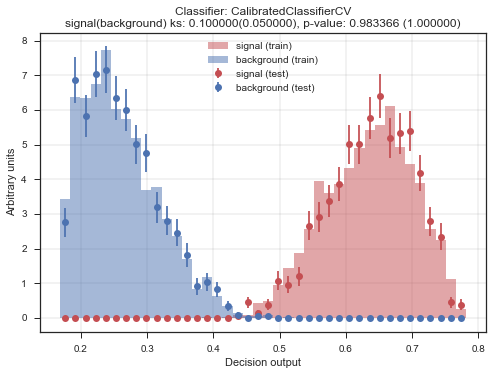

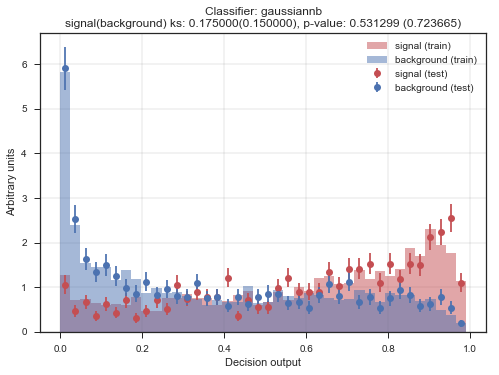

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('gaussiannb', GaussianNB(priors=None))]),
            cv=5, method='sigmoid')

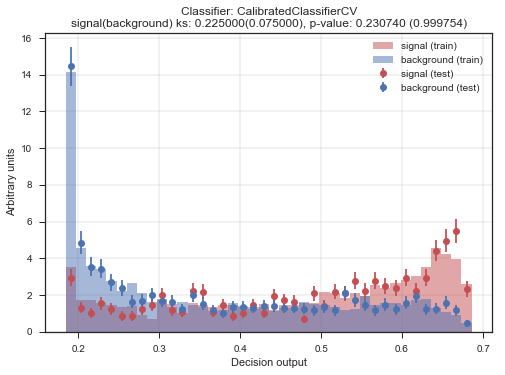


Wall time to generate over-training plots:  63.8061561584
Elapsed time to generate over-traing plots:  63.162533


In [19]:
## Overfitting evaluation

wall = time.time()
process = time.clock()

# Uncalibrated model predictions
model = pipe_classifiers["GRAD"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["ADA"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["SVM"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["LDA"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["KNN"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["LR"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["CART"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["RFC"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)

# Uncalibrated model predictions
model = pipe_classifiers["NB"]
compare_train_test(model, df_X, df_y, bins=40)

# Calibrated with isotonic calibration
model_isotonic = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_isotonic.fit(df_X, df_y)
compare_train_test(model_isotonic, df_X, df_y, bins=40)


print "\nWall time to generate over-training plots: ", time.time()-wall
print "Elapsed time to generate over-traing plots: ", time.clock()-process

## Probability calibration

When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities and some even do not not support probability prediction. Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level.

Two approaches for performing calibration of probabilistic predictions are provided: 
- a parametric approach based on Platt's sigmoid model and a non-parametric approach based on isotonic regression. 

Probability calibration should be done on new data not used for model fitting. The modelue uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the paramter cv="prefit". In this case, the user has to take care manually that data for model fitting and calibration are disjoint.

In [51]:
## Define calibration curve (reliability curve)

def plot_calibration_curve(est, X, y, fig_index, n_bins=10):
    """Plot calibration curve for est w/o and with calibration. """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                                  test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed)
    
    name = est.steps[1][0]
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(6, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")

    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]: # Also called Platt Scaling
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("\n\x1b[1;31mclassifier %s:\x1b[0m" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "o-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=n_bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    # Customize the major grid
    ax1.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax1.set_facecolor('white')
    
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="best", ncol=1)
    
    # Customize the major grid
    ax2.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax2.set_facecolor('white')
    
    plt.tight_layout()
    plt.show()


classifier svc:
	Brier: 0.247
	Precision: 0.000
	Recall: 0.000
	F1: 0.000


classifier svc + Isotonic:
	Brier: 0.242
	Precision: 0.364
	Recall: 0.004
	F1: 0.008


classifier svc + Sigmoid:
	Brier: 0.241
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



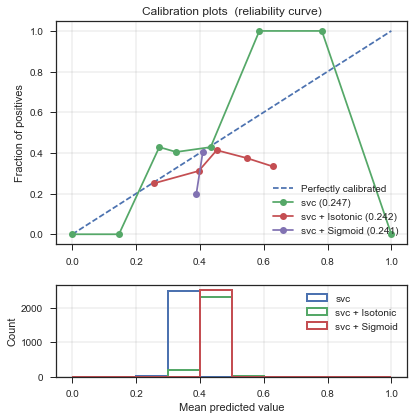


classifier svc:
	Brier: 0.210
	Precision: 0.582
	Recall: 0.703
	F1: 0.637


classifier svc + Isotonic:
	Brier: 0.200
	Precision: 0.632
	Recall: 0.561
	F1: 0.595


classifier svc + Sigmoid:
	Brier: 0.200
	Precision: 0.635
	Recall: 0.560
	F1: 0.595



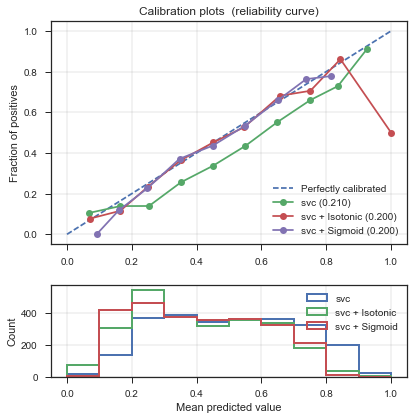


classifier gaussiannb:
	Brier: 0.237
	Precision: 0.549
	Recall: 0.673
	F1: 0.605


classifier gaussiannb + Isotonic:
	Brier: 0.209
	Precision: 0.613
	Recall: 0.446
	F1: 0.516


classifier gaussiannb + Sigmoid:
	Brier: 0.211
	Precision: 0.586
	Recall: 0.534
	F1: 0.559



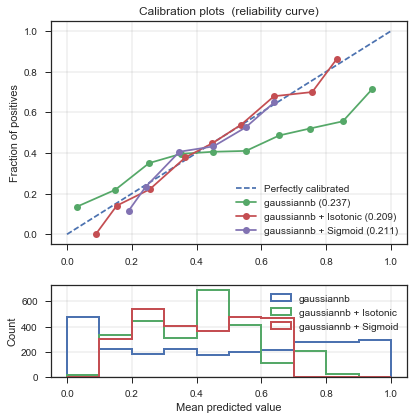


classifier gaussiannb:
	Brier: 0.237
	Precision: 0.551
	Recall: 0.673
	F1: 0.606


classifier gaussiannb + Isotonic:
	Brier: 0.209
	Precision: 0.615
	Recall: 0.441
	F1: 0.514


classifier gaussiannb + Sigmoid:
	Brier: 0.211
	Precision: 0.588
	Recall: 0.536
	F1: 0.561



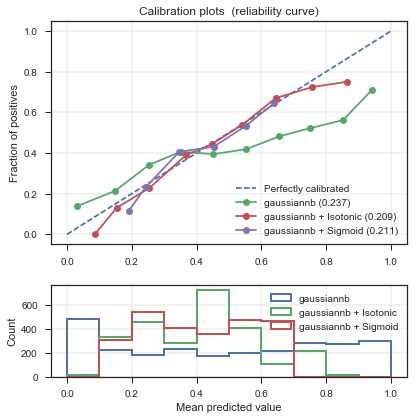


classifier logisticregression:
	Brier: 0.214
	Precision: 0.598
	Recall: 0.448
	F1: 0.512


classifier logisticregression + Isotonic:
	Brier: 0.213
	Precision: 0.580
	Recall: 0.491
	F1: 0.532


classifier logisticregression + Sigmoid:
	Brier: 0.213
	Precision: 0.602
	Recall: 0.449
	F1: 0.514



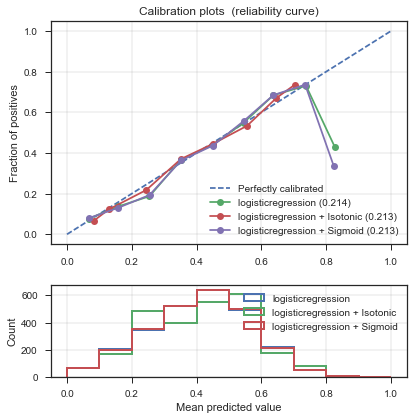


classifier logisticregression:
	Brier: 0.218
	Precision: 0.545
	Recall: 0.700
	F1: 0.613


classifier logisticregression + Isotonic:
	Brier: 0.210
	Precision: 0.576
	Recall: 0.573
	F1: 0.574


classifier logisticregression + Sigmoid:
	Brier: 0.211
	Precision: 0.606
	Recall: 0.464
	F1: 0.526



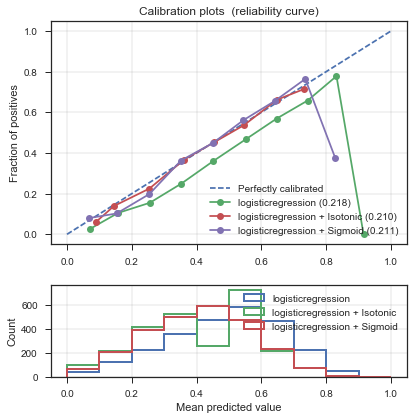


classifier lineardiscriminantanalysis:
	Brier: 0.211
	Precision: 0.598
	Recall: 0.460
	F1: 0.520


classifier lineardiscriminantanalysis + Isotonic:
	Brier: 0.211
	Precision: 0.585
	Recall: 0.483
	F1: 0.529


classifier lineardiscriminantanalysis + Sigmoid:
	Brier: 0.211
	Precision: 0.597
	Recall: 0.457
	F1: 0.518



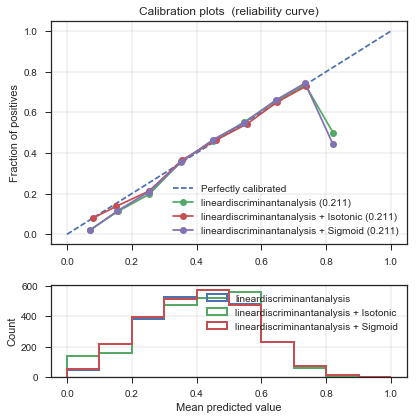


classifier lineardiscriminantanalysis:
	Brier: 0.211
	Precision: 0.598
	Recall: 0.460
	F1: 0.520


classifier lineardiscriminantanalysis + Isotonic:
	Brier: 0.211
	Precision: 0.585
	Recall: 0.483
	F1: 0.529


classifier lineardiscriminantanalysis + Sigmoid:
	Brier: 0.211
	Precision: 0.597
	Recall: 0.457
	F1: 0.518



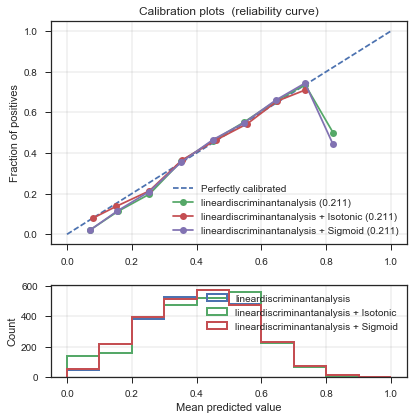


classifier kneighborsclassifier:
	Brier: 0.245
	Precision: 0.539
	Recall: 0.537
	F1: 0.538


classifier kneighborsclassifier + Isotonic:
	Brier: 0.221
	Precision: 0.637
	Recall: 0.260
	F1: 0.369


classifier kneighborsclassifier + Sigmoid:
	Brier: 0.221
	Precision: 0.628
	Recall: 0.286
	F1: 0.393



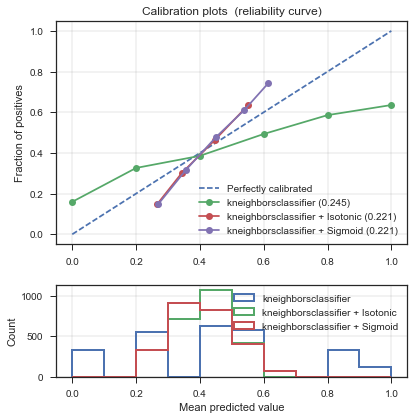


classifier kneighborsclassifier:
	Brier: 0.239
	Precision: 0.562
	Recall: 0.538
	F1: 0.550


classifier kneighborsclassifier + Isotonic:
	Brier: 0.217
	Precision: 0.665
	Recall: 0.349
	F1: 0.457


classifier kneighborsclassifier + Sigmoid:
	Brier: 0.217
	Precision: 0.673
	Recall: 0.306
	F1: 0.421



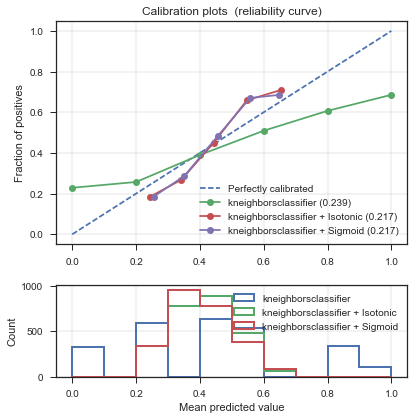


classifier decisiontreeclassifier:
	Brier: 0.276
	Precision: 0.522
	Recall: 0.618
	F1: 0.566


classifier decisiontreeclassifier + Isotonic:
	Brier: 0.218
	Precision: 0.615
	Recall: 0.340
	F1: 0.438


classifier decisiontreeclassifier + Sigmoid:
	Brier: 0.221
	Precision: 0.617
	Recall: 0.303
	F1: 0.406



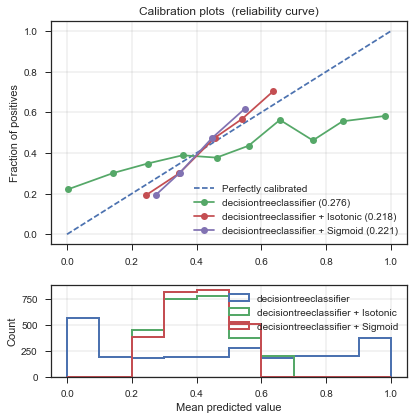


classifier randomforestclassifier:
	Brier: 0.226
	Precision: 0.584
	Recall: 0.439
	F1: 0.501


classifier randomforestclassifier + Isotonic:
	Brier: 0.213
	Precision: 0.607
	Recall: 0.443
	F1: 0.512


classifier randomforestclassifier + Sigmoid:
	Brier: 0.214
	Precision: 0.630
	Recall: 0.393
	F1: 0.484



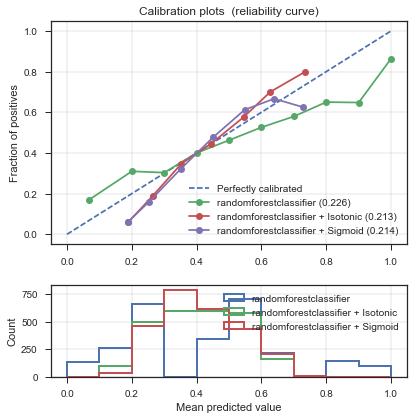


classifier adaboostclassifier:
	Brier: 0.246
	Precision: 0.610
	Recall: 0.578
	F1: 0.594


classifier adaboostclassifier + Isotonic:
	Brier: 0.202
	Precision: 0.649
	Recall: 0.491
	F1: 0.559


classifier adaboostclassifier + Sigmoid:
	Brier: 0.215
	Precision: 0.671
	Recall: 0.226
	F1: 0.338



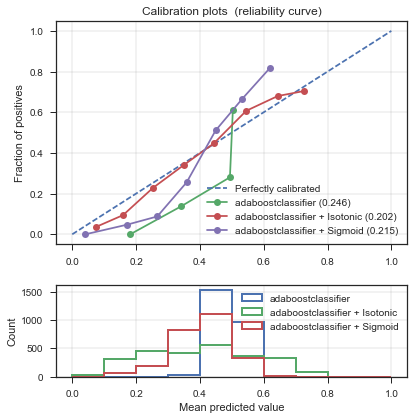


classifier gradientboostingclassifier:
	Brier: 0.200
	Precision: 0.627
	Recall: 0.559
	F1: 0.591


classifier gradientboostingclassifier + Isotonic:
	Brier: 0.199
	Precision: 0.635
	Recall: 0.528
	F1: 0.577


classifier gradientboostingclassifier + Sigmoid:
	Brier: 0.199
	Precision: 0.637
	Recall: 0.536
	F1: 0.582



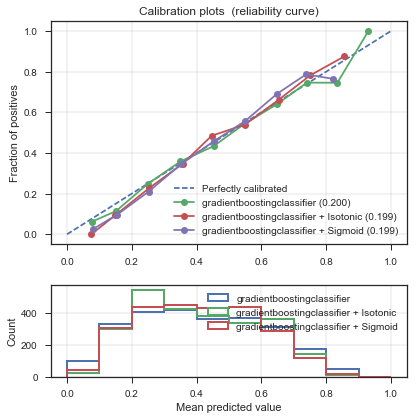


Wall time to generate Calibration (reliability) plots:  32.5719130039
Elapsed time to generate Calibration (reliability) plots:  29.821265


In [52]:
## Plot reliability curve (i.e. calibration curve)

wall = time.time()
process = time.clock()

plot_calibration_curve(make_pipeline(None, SVC()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["SVM"],   df_X, df_y, 2)

plot_calibration_curve(make_pipeline(None, GaussianNB()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["NB"],   df_X, df_y, 2)

plot_calibration_curve(make_pipeline(None, LogisticRegression()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["LR"],   df_X, df_y, 2)

plot_calibration_curve(make_pipeline(None, LinearDiscriminantAnalysis()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["LDA"],  df_X, df_y, 2)

plot_calibration_curve(make_pipeline(None, KNeighborsClassifier()), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["KNN"],  df_X, df_y, 2)

# Tree-based classifier
plot_calibration_curve(pipe_classifiers["CART"], df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["RFC"],  df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["ADA"],  df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["GRAD"], df_X, df_y, 2)

#plot_calibration_curve(pipe_classifiers["MLP"],  df_X, df_y, 2)

print "\nWall time to generate Calibration (reliability) plots: ", time.time()-wall
print "Elapsed time to generate Calibration (reliability) plots: ", time.clock()-process

In [23]:
## Define confusion matrix plot

def plot_confusion_matrix(clf, X, y, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed)
    
    classifier = clf.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap);
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    name = clf.steps[1][0]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False, which='both')
    
    return plt.show()

Confusion matrix, without normalization


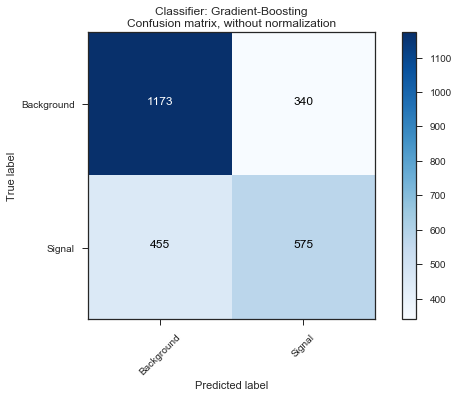

Normalized confusion matrix


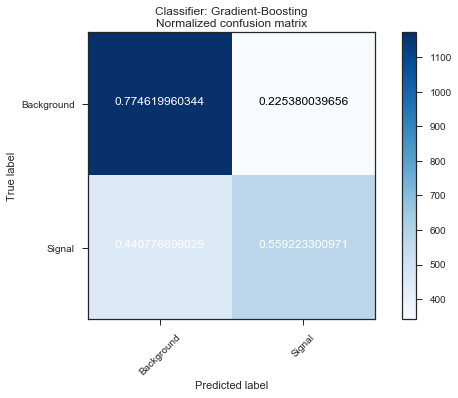

Confusion matrix, without normalization


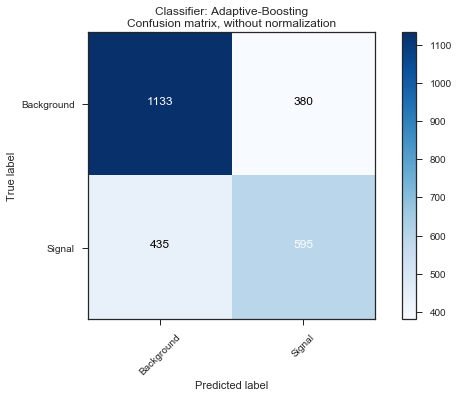

Normalized confusion matrix


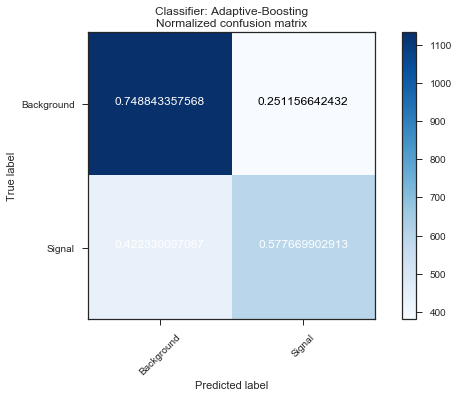

Confusion matrix, without normalization


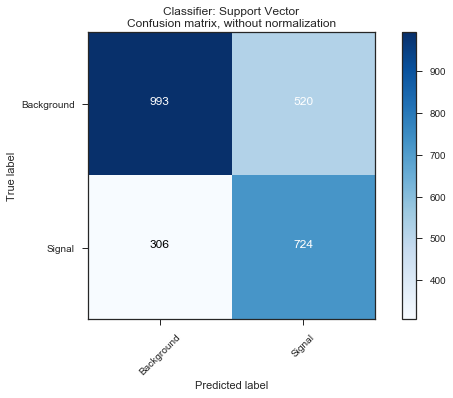

Normalized confusion matrix


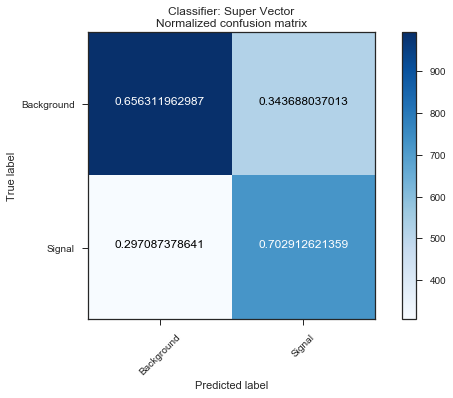

Confusion matrix, without normalization


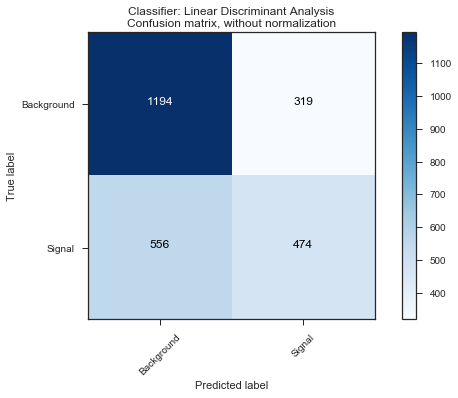

Normalized confusion matrix


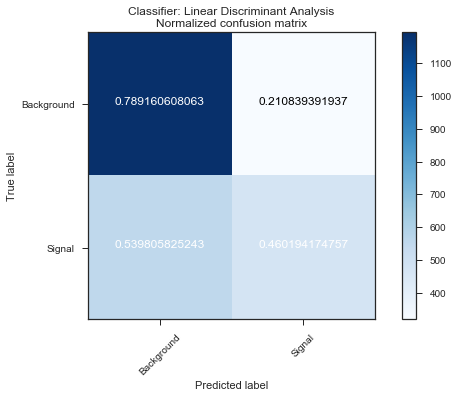

Confusion matrix, without normalization


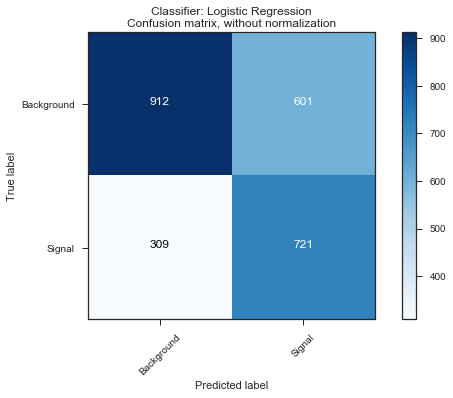

Normalized confusion matrix


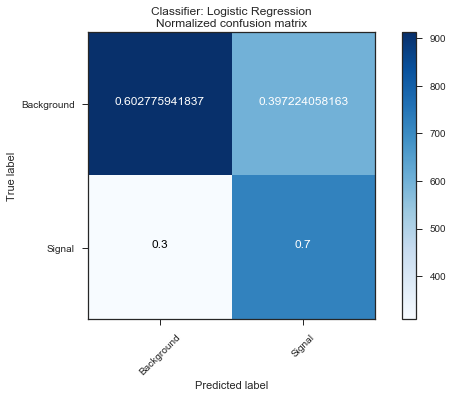

Confusion matrix, without normalization


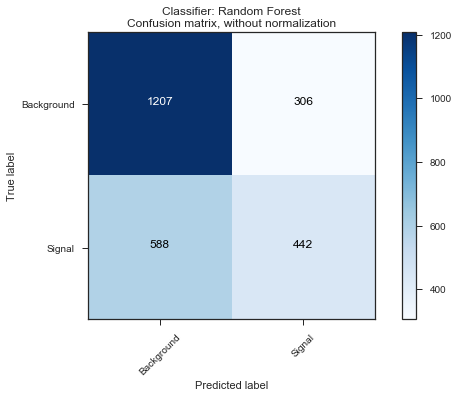

Normalized confusion matrix


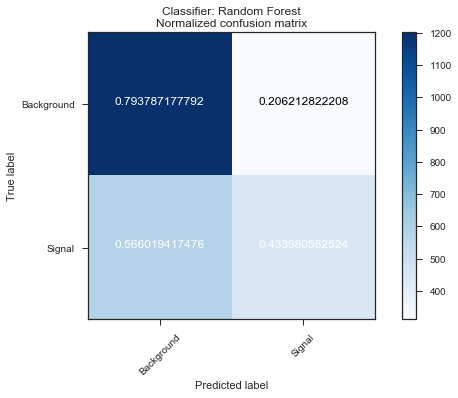

Confusion matrix, without normalization


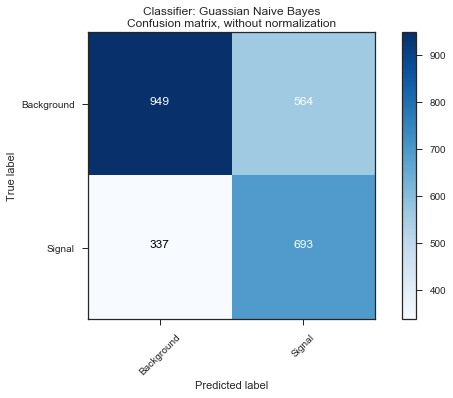

Normalized confusion matrix


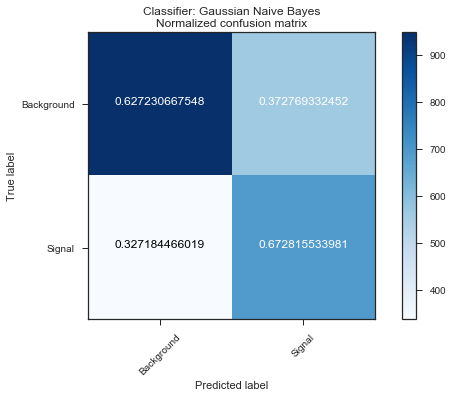

Confusion matrix, without normalization


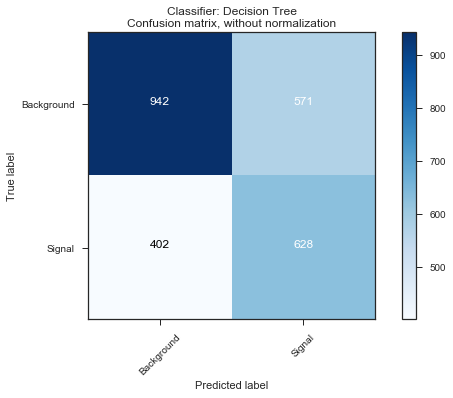

Normalized confusion matrix


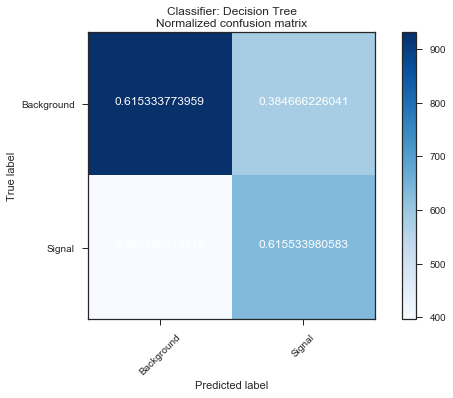

Confusion matrix, without normalization


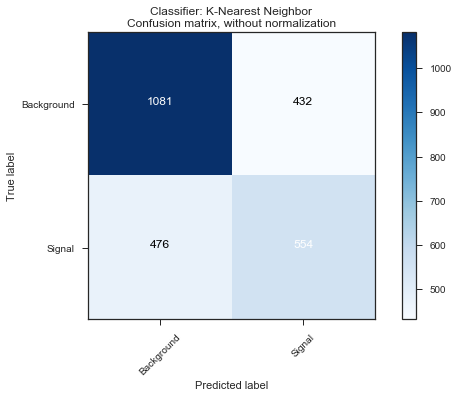

Normalized confusion matrix


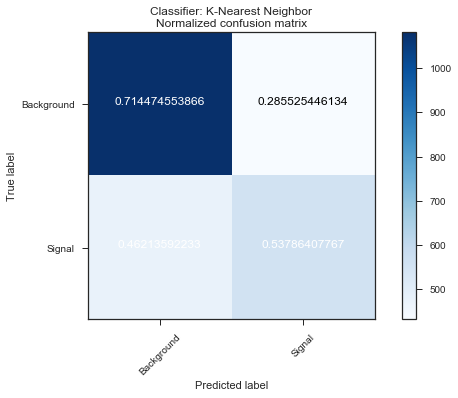


Wall time to generate confusion matrix plots:  13.0046129227
Elapsed time to generate confusion matrix plots:  12.954102


In [24]:
## Generate confusion matrix plot

wall = time.time()
process = time.clock()
    
np.set_printoptions(precision=2)
class_names = ['Background', 'Signal']

# Plot non-normalized confusion matrix
clf = pipe_classifiers["GRAD"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Gradient-Boosting"))
# Plot normalized confusion matrix
clf = pipe_classifiers["GRAD"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Gradient-Boosting"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["ADA"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Adaptive-Boosting"))
# Plot normalized confusion matrix
clf = pipe_classifiers["ADA"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Adaptive-Boosting"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["SVM"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Support Vector"))
# Plot normalized confusion matrix
clf = pipe_classifiers["SVM"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Super Vector"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["LDA"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Linear Discriminant Analysis"))
# Plot normalized confusion matrix
clf = pipe_classifiers["LDA"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Linear Discriminant Analysis"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["LR"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Logistic Regression"))
# Plot normalized confusion matrix
clf = pipe_classifiers["LR"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Logistic Regression"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["RFC"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Random Forest"))
# Plot normalized confusion matrix
clf = pipe_classifiers["RFC"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Random Forest"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["NB"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Guassian Naive Bayes"))
# Plot normalized confusion matrix
clf = pipe_classifiers["NB"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Gaussian Naive Bayes"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["CART"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("Decision Tree"))
# Plot normalized confusion matrix
clf = pipe_classifiers["CART"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("Decision Tree"))

# Plot non-normalized confusion matrix
clf = pipe_classifiers["KNN"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names,
                      title="Classifier: %s\nConfusion matrix, without normalization"%("K-Nearest Neighbor"))
# Plot normalized confusion matrix
clf = pipe_classifiers["KNN"]
plot_confusion_matrix(clf, df_X, df_y, classes=class_names, normalize=True,
                      title="Classifier: %s\nNormalized confusion matrix"%("K-Nearest Neighbor"))

print "\nWall time to generate confusion matrix plots: ", time.time()-wall
print "Elapsed time to generate confusion matrix plots: ", time.clock()-process

## Early stopping: Validation Plots

To validate a model we need a scoring function, for example accuracy for classifiers. The proper way of choosing multiple hyperparameters of an estimator are of course grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. Note that if we optimized the hyperparameters based on a validation score the validation score is biased and not a good estimate of the generalization any longer. To get a proper estimate of the generalization we have to compute the score on another test set.

However, it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values.

measure the performance of our ensemble as we go along and stop adding trees 
once we think we have reached the minimum (min. test error).

It will repeatedly add one more base estimator to the ensemble, measure the performance, and check if we reached minimum. If we reached the minimum it stops, otherwise it keeps adding base estimators until it reaches the maximum number of iterations.

- There is a minimum number of trees required to skip over the noisier part of the score function
- Early stopping does not actually stop at the minimum, instead it continues on until the score has increased by scale above the current minimum. This is a simple solution to the problem that we only know we reached the minimum by seeing the score increase again.

In [53]:
## Validation curve definition

def validation_curve(clf, X, y):
    """Validation curve.

    Parameters
    ----------
    clf : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    X : array, shape = [n_samples, n_classes]
    y : array, shape = [n_samples, n_classes]
    Returns
    -------
    plt : matplotlib
    """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev, y_eval = train_test_split(X, y, test_size=.33,
                                                   random_state=seed)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed+31415)

    clf.fit(X_train, y_train)

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    test_score = np.empty(len(clf.estimators_))
    train_score = np.empty(len(clf.estimators_))

    for i, pred in enumerate(clf.staged_predict_proba(X_test)):
        test_score[i] = 1-roc_auc_score(y_test, pred[:,1])

    for i, pred in enumerate(clf.staged_predict_proba(X_train)):
        train_score[i] = 1-roc_auc_score(y_train, pred[:,1])

    best_iter = np.argmin(test_score)
    learn = clf.get_params()['learning_rate']
    depth = clf.get_params()['max_depth']
        
    test_line = plt.plot(test_score, label='test (1-roc_auc=%.3f)'%(test_score[best_iter]))

    colour = test_line[-1].get_color()
    plt.plot(train_score, '--', color=colour, label='train (1-roc_auc=%.3f)\nlearn=%.1f depth=%i'
             %(train_score[best_iter],learn,depth))

    plt.title("Validation curve")
    plt.xlabel("Number of boosting iterations")
    plt.ylabel("1 - area under ROC")
    plt.legend(loc='best')
    plt.axvline(x=best_iter, color=colour)
    
    return plt.show()

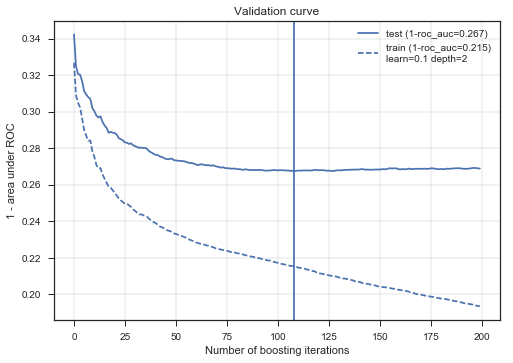


Wall time to generate Validation plots:  1.90414595604
Elapsed time to generate Validation plots:  1.890226


In [29]:
##  plot the validation curve for our fitted classifier
# and check with the test set at which number of n_estimators we reach the minimum test error.

wall = time.time()
process = time.clock()

# Set of hyper-parameter selected
opts = dict(max_depth=2, learning_rate=0.1, n_estimators=200)

clf = GradientBoostingClassifier(**opts)

validation_curve(clf, df_X, df_y)

print "\nWall time to generate Validation plots: ", time.time()-wall
print "Elapsed time to generate Validation plots: ", time.clock()-process

## Threshold optimisation

what happens if we use a different hyper-parameter: the threshold applied to decide which class a sample falls in during prediction time, that is normally defaulted to 0.5 threshold.

##  Learning curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. 

In [65]:
# Define learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_val_score>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.legend(loc="best")

    
    return plt.show()

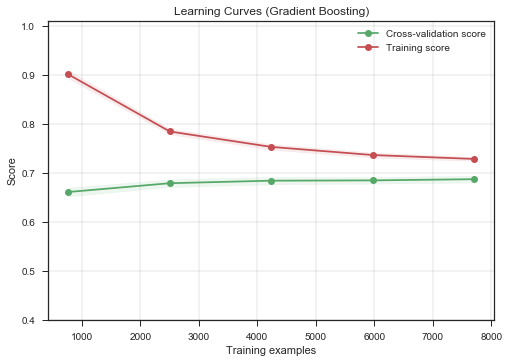


Wall time to generate Learning curve plots:  17.7693219185
Elapsed time to generate Learning curve plots:  2.121856


In [66]:
## Plot learning curve

wall = time.time()
process = time.clock()

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

estimator = GradientBoostingClassifier()
plot_learning_curve(estimator, "Learning Curves (Gradient Boosting)", df_X, df_y, ylim=(0.4, 1.01), cv=cv, n_jobs=-1);

print "\nWall time to generate Learning curve plots: ", time.time()-wall
print "Elapsed time to generate Learning curve plots: ", time.clock()-process

## Feature Ranking and Feature Selection

There are various methods for determining feature importance, namely, model-based selection, variance based selection, univariate statistics selections, recursive feature elemination, iterative selection.

In [67]:
## Define feature ranking 

def feature_ranking_plot(X, indices, title):

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    print(title)
    for i in range(X.shape[1]):
        print("%d. %s (%f)" % (i + 1, X.columns[indices[i]], importances[indices[i]]))
    
    #std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #         axis=0)
    
    # Plot the feature importances of the model
    plt.title(title)
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", align="center") #yerr=std[indices]
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()

    return plt.show()

In [101]:
## define extract feature selection

def extract_feature_selected(clf, X, y):
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev, y_eval = train_test_split(df_X, df_y, test_size=.33, 
                                                   random_state=seed)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed+31415)

    clf.fit(X_train, y_train)
    select_indices = clf.named_steps['SELECT'].transform(
    np.arange(len(X_train.columns)).reshape(1, -1))

    feature_names = X_train.columns[select_indices]
    
    return feature_names

In [102]:
## Feature selection study

def features_selection_model_performance(clf, X, y, parameter_set):

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    this_scores = list()
    score_means = list()
    score_stds = list()

    params = {'SELECT__k': 'top k features', 
              'SELECT__threshold': 'feature threshold',
              'SELECT__n_features_to_select': 'n features to select',
              'SELECT__percentile': 'percentile',
              'SELECT__cv': 'k-fold',
              'SELECT__selection_threshold':'selection threshold'}
    
    label = [keyname for keyname in clf.get_params().keys() if keyname in params.keys()][0]
    
    for k in parameter_set:

        param = {label: k}
        clf.set_params(**param) 
        
        # Compute cross-validation score using 1 CPU
        this_scores = cross_val_score(clf, X, y, cv=3, n_jobs=1)
        score_means.append(this_scores.mean())
        score_stds.append(this_scores.std())

    plt.errorbar(parameter_set, score_means, np.array(score_stds))

    model = clf.steps[1][0]

    title = 'Performance of the {}-{} varying for features selected'.format(model,
                                                                            clf.get_params().keys()[1])
    
    plt.title(title)
    plt.xlabel(params[label])
    plt.ylabel('Prediction rate')

    print  extract_feature_selected(clf, X, y)
    
    return plt.show()

Feature importances based on variance ranking
1. mass_tag_tag_max_mass (27868.014265)
2. HT_tags (21949.610249)
3. median_mass_jet_jet (2819.712764)
4. mass_tag_tag_min_deltaR (1967.980361)
5. mass_jet_tag_min_deltaR (1217.803636)
6. mass_jet_jet_min_deltaR (1167.611945)
7. mass_higgsLikeDijet (160.117972)
8. maxDeltaEta_jet_jet (0.874603)
9. maxDeltaEta_tag_tag (0.728164)
10. centrality_tags (0.027508)
11. centrality_jets_leps (0.019689)
12. btagDiscriminatorAverage_tagged (0.000524)


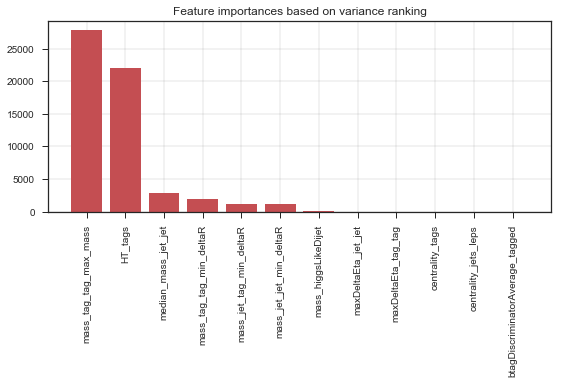

Index([[u'mass_tag_tag_min_deltaR', u'median_mass_jet_jet', u'mass_higgsLikeDijet', u'HT_tags', u'mass_jet_tag_min_deltaR', u'mass_jet_jet_min_deltaR', u'mass_tag_tag_max_mass']], dtype='object')


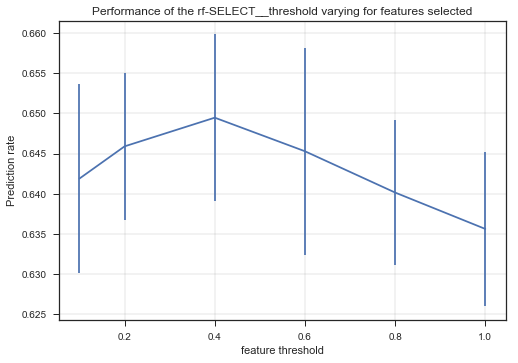

Wall time to produce feature ranking plots:  20431.2448909
Elapsed time to prodduce feature ranking plots:  5.542856


In [170]:
## Univariate Statistics

process = time.time()
process = time.clock()

# Removing features with low variance
select = VarianceThreshold()
p = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

clf = Pipeline([('SELECT', select), ('rf', RandomForestClassifier())])

# Features selected by variance threshold
_= clf.named_steps["SELECT"].fit_transform(df_X)

importances = clf.named_steps["SELECT"].variances_
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, indices, "Feature importances based on variance ranking")

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)

print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

Feature importances based k-best features classification ranking
1. maxDeltaEta_tag_tag (821.782410)
2. centrality_tags (530.260193)
3. centrality_jets_leps (474.235596)
4. maxDeltaEta_jet_jet (443.136047)
5. btagDiscriminatorAverage_tagged (278.210449)
6. mass_jet_tag_min_deltaR (143.928436)
7. mass_jet_jet_min_deltaR (141.586960)
8. mass_tag_tag_max_mass (135.834778)
9. mass_tag_tag_min_deltaR (111.955536)
10. HT_tags (64.136314)
11. median_mass_jet_jet (10.709892)
12. mass_higgsLikeDijet (2.597515)


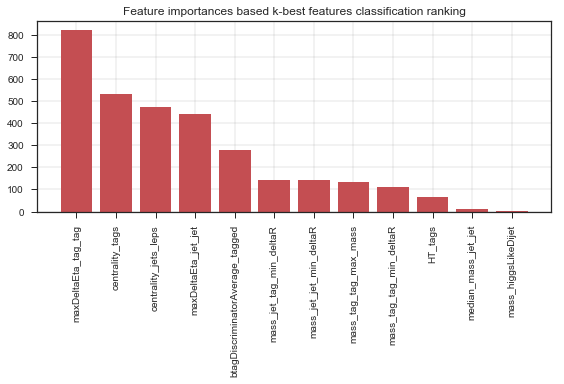

Index([[u'mass_tag_tag_min_deltaR', u'median_mass_jet_jet', u'maxDeltaEta_tag_tag', u'mass_higgsLikeDijet', u'HT_tags', u'btagDiscriminatorAverage_tagged', u'mass_jet_tag_min_deltaR', u'mass_jet_jet_min_deltaR', u'mass_tag_tag_max_mass', u'maxDeltaEta_jet_jet', u'centrality_jets_leps', u'centrality_tags']], dtype='object')


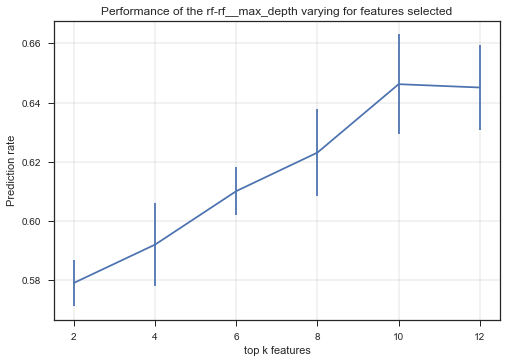

Wall time to produce feature ranking plots:  20436.468806
Elapsed time to prodduce feature ranking plots:  5.080809


In [171]:
# K-best features
process = time.time()
process = time.clock()

#  Univariate feature selection based on the k highest scores
select = SelectKBest(score_func=f_classif, k=6)
p = [2, 4, 6, 8, 10, 12]

clf = Pipeline([('SELECT', select), ('rf', RandomForestClassifier())])

# Features selected based on k-highest scores
_= clf.named_steps["SELECT"].fit_transform(df_X, df_y)

importances = clf.named_steps["SELECT"].scores_
std = np.std([score for score in clf.named_steps["SELECT"].scores_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, indices, "Feature importances based k-best features classification ranking")

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

Feature importances based percentile of the highest feature scores classification ranking
1. maxDeltaEta_tag_tag (821.782410)
2. centrality_tags (530.260193)
3. centrality_jets_leps (474.235596)
4. maxDeltaEta_jet_jet (443.136047)
5. btagDiscriminatorAverage_tagged (278.210449)
6. mass_jet_tag_min_deltaR (143.928436)
7. mass_jet_jet_min_deltaR (141.586960)
8. mass_tag_tag_max_mass (135.834778)
9. mass_tag_tag_min_deltaR (111.955536)
10. HT_tags (64.136314)
11. median_mass_jet_jet (10.709892)
12. mass_higgsLikeDijet (2.597515)


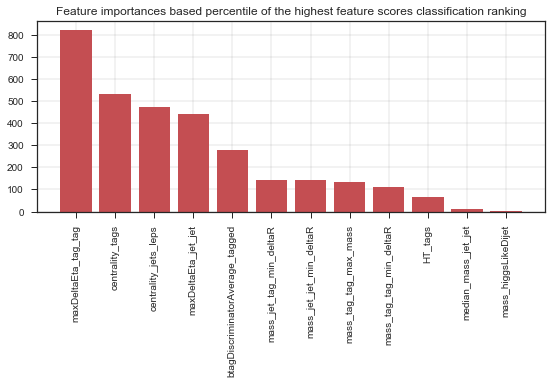

Index([[u'mass_tag_tag_min_deltaR', u'median_mass_jet_jet', u'maxDeltaEta_tag_tag', u'mass_higgsLikeDijet', u'HT_tags', u'btagDiscriminatorAverage_tagged', u'mass_jet_tag_min_deltaR', u'mass_jet_jet_min_deltaR', u'mass_tag_tag_max_mass', u'maxDeltaEta_jet_jet', u'centrality_jets_leps', u'centrality_tags']], dtype='object')


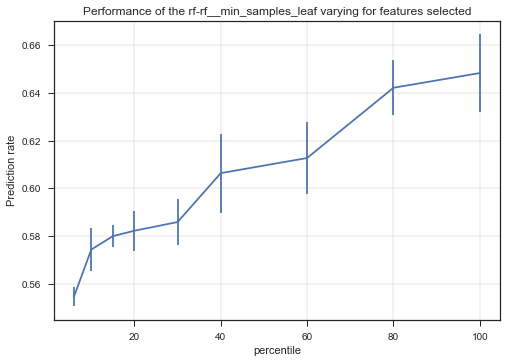

Wall time to produce feature ranking plots:  20442.8919411
Elapsed time to prodduce feature ranking plots:  6.336489


In [172]:
# Percentile of the highest feature scores 

process = time.time()
process = time.clock()

# Univariate feature selection according to a percentile of the highest scores
select = feature_selection.SelectPercentile(f_classif)
p = (6, 10, 15, 20, 30, 40, 60, 80, 100)

clf = Pipeline([('SELECT', select), ('rf', RandomForestClassifier())])

# Features selected based on k-highest scores
_= clf.named_steps["SELECT"].fit_transform(df_X, df_y)

importances = clf.named_steps["SELECT"].scores_
std = np.std([score for score in clf.named_steps["SELECT"].scores_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, indices, "Feature importances based percentile of the highest feature scores classification ranking")

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)

print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

Feature importances based recursive feature elimination classification ranking
1. mass_jet_jet_min_deltaR (7.000000)
2. median_mass_jet_jet (6.000000)
3. HT_tags (5.000000)
4. mass_higgsLikeDijet (4.000000)
5. centrality_tags (3.000000)
6. mass_jet_tag_min_deltaR (2.000000)
7. centrality_jets_leps (1.000000)
8. maxDeltaEta_jet_jet (1.000000)
9. mass_tag_tag_max_mass (1.000000)
10. btagDiscriminatorAverage_tagged (1.000000)
11. maxDeltaEta_tag_tag (1.000000)
12. mass_tag_tag_min_deltaR (1.000000)


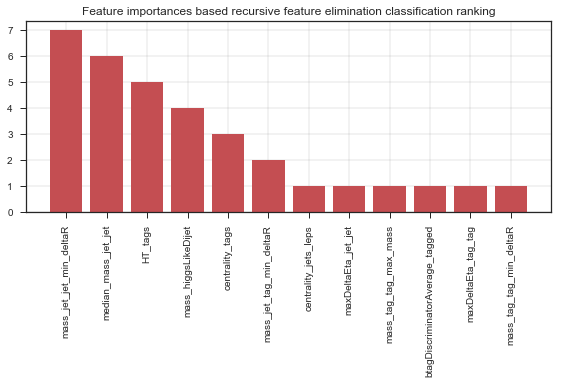

Index([[u'mass_tag_tag_min_deltaR', u'median_mass_jet_jet', u'maxDeltaEta_tag_tag', u'mass_higgsLikeDijet', u'HT_tags', u'btagDiscriminatorAverage_tagged', u'mass_jet_tag_min_deltaR', u'mass_jet_jet_min_deltaR', u'mass_tag_tag_max_mass', u'maxDeltaEta_jet_jet', u'centrality_jets_leps', u'centrality_tags']], dtype='object')


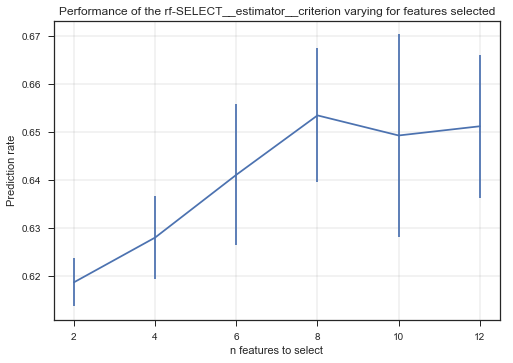

Wall time to produce feature ranking plots:  20474.295934
Elapsed time to prodduce feature ranking plots:  30.86658


In [173]:
# Recursive feature elimination

process = time.time()
process = time.clock()

# Recursive feature elimination by recursively removing attributes 
# and building a model on those attributes that remain.
select = RFE(estimator=RandomForestClassifier(), step=1)
p = [2, 4, 6, 8, 10, 12]

clf = Pipeline([('SELECT', select), ('rf', RandomForestClassifier())])

# Features selected based on recursive feature elmination
_= clf.named_steps["SELECT"].fit_transform(df_X, df_y)

importances = clf.named_steps["SELECT"].ranking_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, indices, "Feature importances based recursive feature elimination classification ranking")

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

Index([[u'mass_tag_tag_min_deltaR', u'median_mass_jet_jet', u'maxDeltaEta_tag_tag', u'mass_higgsLikeDijet', u'HT_tags', u'btagDiscriminatorAverage_tagged', u'mass_jet_jet_min_deltaR', u'mass_tag_tag_max_mass', u'maxDeltaEta_jet_jet', u'centrality_jets_leps', u'centrality_tags']], dtype='object')


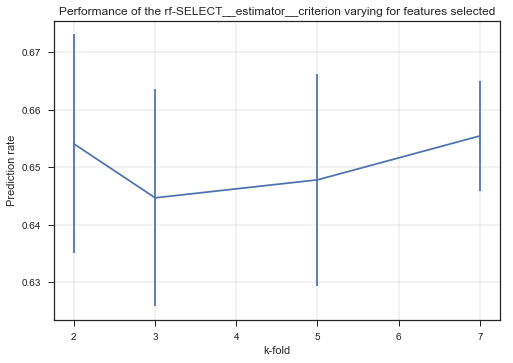

RFECV odel-based feature importances ranking
1. mass_tag_tag_min_deltaR (0.104702)
2. maxDeltaEta_tag_tag (0.099322)
3. centrality_tags (0.088225)
4. maxDeltaEta_jet_jet (0.086871)
5. mass_tag_tag_max_mass (0.084202)
6. btagDiscriminatorAverage_tagged (0.083551)
7. centrality_jets_leps (0.082899)
8. HT_tags (0.078279)
9. mass_higgsLikeDijet (0.077848)
10. median_mass_jet_jet (0.076090)
11. mass_jet_tag_min_deltaR (0.070944)
12. mass_jet_jet_min_deltaR (0.067066)


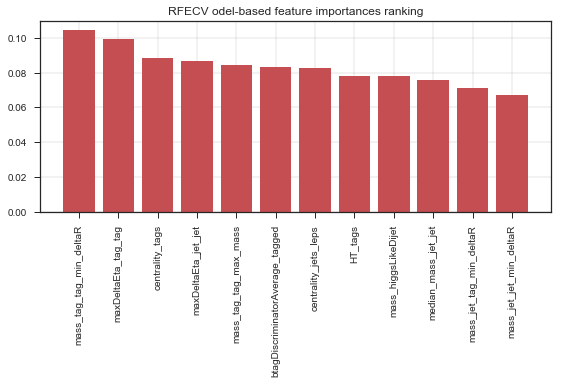

Wall time to produce feature ranking plots:  20606.4840219
Elapsed time to prodduce feature ranking plots:  129.248093


In [174]:
# Recursive feature elimination with cross-validation

process = time.time()
process = time.clock()

# Recursive feature elimination with cross-validation
select = RFECV(estimator=RandomForestClassifier(), step=1, 
               cv=StratifiedKFold(3), scoring='accuracy')
p = [2, 3, 5, 7]

# Features selected based on k-highest scores
_= clf.named_steps["SELECT"].fit_transform(df_X, df_y)

importances = clf.named_steps["SELECT"].estimator_.feature_importances_ #.ranking_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

clf = Pipeline([('SELECT', select), ('rf', RandomForestClassifier())])

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)

# Plot feature ranking
feature_ranking_plot(df_X, indices, "RFECV odel-based feature importances ranking")


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

Index([[u'mass_tag_tag_min_deltaR', u'maxDeltaEta_tag_tag']], dtype='object')


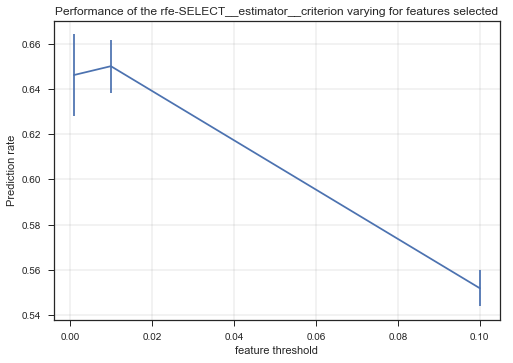

ExtraTree Model-based feature importances ranking
1. maxDeltaEta_tag_tag (0.104897)
2. mass_tag_tag_min_deltaR (0.099431)
3. centrality_tags (0.088322)
4. btagDiscriminatorAverage_tagged (0.084815)
5. centrality_jets_leps (0.083134)
6. maxDeltaEta_jet_jet (0.082753)
7. mass_jet_jet_min_deltaR (0.078254)
8. mass_jet_tag_min_deltaR (0.077868)
9. HT_tags (0.076469)
10. mass_higgsLikeDijet (0.076109)
11. median_mass_jet_jet (0.074157)
12. mass_tag_tag_max_mass (0.073792)


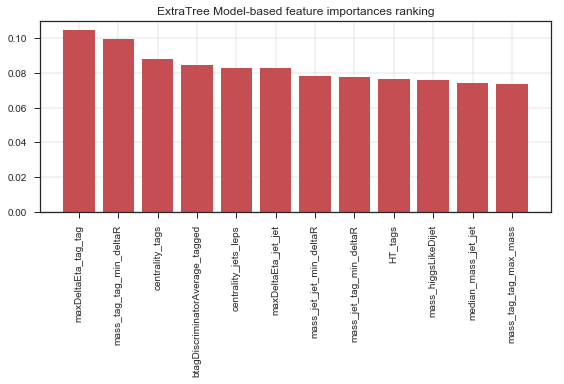


Wall time to generate features selection performance plots:  21466.367063
Elapsed time to generate features selection performance plots:  154.717808


In [181]:
# Build a forest and compute the feature importances
extra_forest = ExtraTreesClassifier(random_state=0)
select = SelectFromModel(extra_forest, threshold="median")
p = [0.001, 0.01, 0.1] # any higher crash

clf = Pipeline([('SELECT', select), ('rfe', RandomForestClassifier())])

# Features selected by SelectFromModel using the ExtraTreesClassifier
_= clf.named_steps["SELECT"].fit(df_X, df_y)

importances = clf.named_steps["SELECT"].estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)

# Plot feature ranking
feature_ranking_plot(df_X, indices, "ExtraTree Model-based feature importances ranking")

print "\nWall time to generate features selection performance plots: ", time.time()-wall
print "Elapsed time to generate features selection performance plots: ", time.clock()-process

RandomForestClassifier model-based feature importances ranking
1. maxDeltaEta_tag_tag (0.106134)
2. mass_tag_tag_min_deltaR (0.103442)
3. centrality_tags (0.092416)
4. btagDiscriminatorAverage_tagged (0.085818)
5. centrality_jets_leps (0.083654)
6. maxDeltaEta_jet_jet (0.080235)
7. mass_tag_tag_max_mass (0.079392)
8. HT_tags (0.079090)
9. mass_higgsLikeDijet (0.077113)
10. median_mass_jet_jet (0.074602)
11. mass_jet_tag_min_deltaR (0.070558)
12. mass_jet_jet_min_deltaR (0.067546)


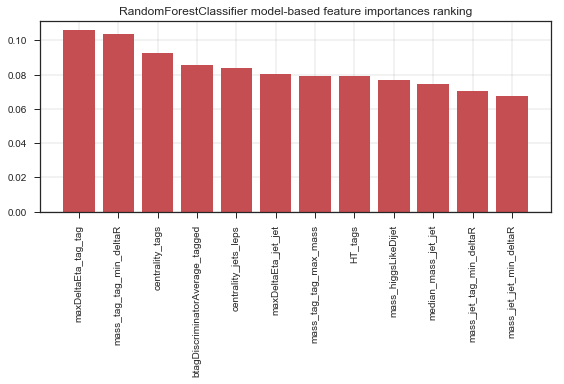

Index([[u'mass_tag_tag_min_deltaR', u'maxDeltaEta_tag_tag']], dtype='object')


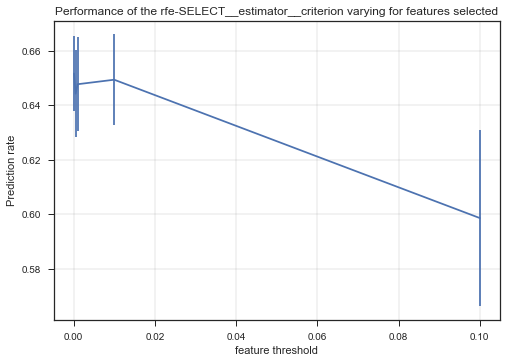

Wall time to produce feature ranking plots:  21491.6632421
Elapsed time to prodduce feature ranking plots:  163.896885


In [182]:
# The SelectFromModel class selects all features that have an importance measure 
# of the feature (as provided by the supervised model) greater than the provided 
# threshold.
#select = SelectFromModel(RandomForestClassifier(min_samples_leaf=0.0001), threshold=0.5)
select = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=seed))
#p = ["mean", "median"]
p = [0.0001, 0.0005, 0.001, 0.01, 0.1] # any higher crash

clf = Pipeline([('SELECT', select), ('rfe', RandomForestClassifier())])

# Features selected by SelectFromModel using the ExtraTreesClassifier
_= clf.named_steps["SELECT"].fit(df_X, df_y)

importances = clf.named_steps["SELECT"].estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, indices, "RandomForestClassifier model-based feature importances ranking")

# Plot feature selection
features_selection_model_performance(clf, df_X, df_y, p)


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))

#sns.heatmap(np.c_[df_X.values, df_y.values],names=features+['y'])

#sns.corrplot(data, ax=ax,names=features+['y'])

In [43]:
## Overly inblanced datat set between signal and background composition

RANDOM_STATE = 42

class DummySampler(object):

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return self.sample(X, y)

samplers = [
    ['Standard', DummySampler()],
    ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
]



#smote = SMOTE(random_state=RANDOM_STATE)
#cart = DecisionTreeClassifier(random_state=RANDOM_STATE)
#pipeline = make_pipeline(smote, cart)

#param_range = range(1, 11)
#train_scores, test_scores = ms.validation_curve(
#    pipeline, X, y, param_name="smote__k_neighbors", param_range=param_range,
#    cv=3, scoring=scorer, n_jobs=1)
#train_scores_mean = np.mean(train_scores, axis=1)
#train_scores_std = np.std(train_scores, axis=1)
#test_scores_mean = np.mean(test_scores, axis=1)
#test_scores_std = np.std(test_scores, axis=1)

#plt.title("Validation Curve with SMOTE-CART")
#plt.xlabel("k_neighbors")
#plt.ylabel("Cohen's kappa")
#plt.plot(param_range, test_scores_mean, color="navy", lw=2)
#plt.legend(loc="best")
#plt.show()

In [44]:
# Apply the random over-sampling
ros = RandomOverSampler()
X_overresampled, y_overresampled = ros.fit_sample(df_X, df_y)

# Apply the random under-sampling
rus = RandomUnderSampler()
X_underresampled, y_underresampled = rus.fit_sample(df_X, df_y)

# Apply SMOTE SVM
sm = SMOTE(kind='svm')
X_resampled, y_resampled = sm.fit_sample(df_X, df_y)

In [45]:
# Split data into a development and evaluation set
X_dev,X_eval, y_dev, y_eval = train_test_split(df_X, df_y, test_size=.33, 
                                                   random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed+31415)

## Repeated nested k-fold cross-validatation

Change random splitting after each cross-validaiton

In [183]:
# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y,
                                              test_size=0.33, random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                    random_state=seed)

# Removing features with low variance
select = VarianceThreshold()
#pipe_param_grid = {'variancethreshold__threshold': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]}
pipe_param_grid = {'randomforestclassifier__max_depth': [100],#[70, 100],
                   'randomforestclassifier__max_features': [7], #[4, 6],
                   #'variancethreshold__threshold': [0.9] #[0.4, 0.6, 0.8, 1.0]
                  }

grids = [GridSearchCV(make_pipeline(select, RandomForestClassifier(random_state=seed+n_iter)),
                      param_grid=pipe_param_grid, n_jobs=1, verbose=0).fit(X_train, y_train)
         for n_iter in range(10)]

scores = [grid.best_score_ for grid in grids]
print("Average score: %.4f+-%.4f" %(np.mean(scores), sp.stats.sem(scores)))



Average score: 0.6482+-0.0010


## Machine Learning Algorithms for Model Building

### Hyper-parameter Optimization and Model Evaluation

We employ a nested k-fold cross-validation utilizaiton a grid search for hyper-parameter optimization to avoid leaking information from the training dataset used to validate the hyper-parameters into the model evaluation which uses testing datasets.

We preform a hyper-parameter optimization to improve the accuary of our Gradient Boosting Classifier model then we evaluate the best cross-validated model in a hold out dataset that was not used during hyper-parameter validation.

In [297]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = SelectKBest(k=8)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     #'classifier__random_state': [seed],
     'feature_selection': [select],
     'feature_selection__k': [10],
     'feature_scaling': [scaler]
    }
]

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=1)
pcv.fit(X_train, y_train)


grids = [GridSearchCV(make_pipeline(select, RandomForestClassifier(random_state=seed+n_iter)),
                      param_grid=pipe_param_grid, n_jobs=1, verbose=0).fit(X_train, y_train)
         for n_iter in range(10)]

#print [seed+n_iter for n_iter in range(10)]
#grids = [pcv.set_params(**{'classifier__random_state': seed+n_iter}).fit(X_train, y_train) for n_iter in range(10)]

scores = [grid.best_score_ for grid in grids]
print("Average score: %.4f+-%.4f" %(np.mean(scores), sp.stats.sem(scores)))

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'classifier__learning_rate': [0.1], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'classifier__n_estimators': [100], 'feature_selection__k': [10], 'feature_selection': [SelectKBest(k=10, score_func=<function f_c...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Average score: 0.6437+-0.0009
             precision    recall  f1-score   support

        0.0       0.71      0.79      0.75      1502
        1.0       0.64      0.54      0.58      1041

avg / total       0.68      0.69      0.68      2543



In [298]:
print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))

Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
GradientBoostingClassifier classifier step:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best cross-validation accuracy: 0.67
Test set score: 0.69
Best parameters: {'classifier__learning_rate': 0.1, 'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__n_estimators': 100, 'feature_selection__k': 10, 'feature_selection': SelectKBest(k=10, score_func=<fun

In [221]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = VarianceThreshold()

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__threshold': [0.4],
     'feature_scaling': [scaler]
    }
]

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=1)
pcv.fit(X_train, y_train)

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'feature_selection__threshold': [0.4], 'classifier__learning_rate': [0.1], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'classifier__n_estimators': [100], 'feature_selection': [VarianceThreshold(threshold=0.4)]...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.72      0.79      0.75      1502
        1.0       0.65      0.55      0.60      1041

avg / total       0.69      0.69      0.69      2543



In [222]:
print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))

Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
GradientBoostingClassifier classifier step:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best cross-validation accuracy: 0.67
Test set score: 0.69
Best parameters: {'feature_selection__threshold': 0.4, 'classifier__learning_rate': 0.1, 'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__n_estimators': 100, 'feature_selection': VarianceThreshold(thresh

In [223]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = feature_selection.SelectPercentile(f_classif)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__percentile': [90],
     'feature_scaling': [scaler]
    }
]

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=1)
pcv.fit(X_train, y_train)

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'feature_selection__percentile': [90], 'classifier__learning_rate': [0.1], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'classifier__n_estimators': [100], 'feature_selection': [SelectPercentile(percentile=90,
 ...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.71      0.79      0.75      1502
        1.0       0.64      0.54      0.59      1041

avg / total       0.68      0.69      0.68      2543



In [224]:
print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))

Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
GradientBoostingClassifier classifier step:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best cross-validation accuracy: 0.67
Test set score: 0.69
Best parameters: {'feature_selection__percentile': 90, 'classifier__learning_rate': 0.1, 'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__n_estimators': 100, 'feature_selection': SelectPercentile(percent

In [225]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = RFE(estimator=RandomForestClassifier(), n_features_to_select=8, step=1)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__n_features_to_select': [10],
     'feature_scaling': [scaler]
    }
]

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=1)
pcv.fit(X_train, y_train)

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'feature_selection__n_features_to_select': [10], 'classifier__learning_rate': [0.1], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'classifier__n_estimators': [100], 'feature_selection': [RFE(estimator=RandomFor...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.72      0.79      0.75      1502
        1.0       0.65      0.55      0.59      1041

avg / total       0.69      0.69      0.69      2543



In [226]:
print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))

Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
GradientBoostingClassifier classifier step:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best cross-validation accuracy: 0.67
Test set score: 0.69
Best parameters: {'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__learning_rate': 0.1, 'feature_selection__n_features_to_select': 10, 'classifier__n_estimators': 100, 'feature_selection': RFE(estimator=

In [227]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = RFECV(estimator=RandomForestClassifier(), step=1,  
               cv=StratifiedKFold(3), scoring='accuracy')

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__cv': [7],
     'feature_scaling': [scaler]
    }
]

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=1)
pcv.fit(X_train, y_train)

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'classifier__learning_rate': [0.1], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'classifier__n_estimators': [100], 'feature_selection__cv': [7], 'feature_selection': [RFECV(cv=7,
   estimator=RandomForestClass...100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.72      0.79      0.75      1502
        1.0       0.65      0.55      0.59      1041

avg / total       0.69      0.69      0.69      2543



In [229]:
print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))

Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
GradientBoostingClassifier classifier step:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Best cross-validation accuracy: 0.67
Test set score: 0.69
Best parameters: {'classifier__learning_rate': 0.1, 'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__n_estimators': 100, 'feature_selection__cv': 7, 'feature_selection': RFECV(cv=7,
   estimator=RandomFo

In [230]:
# now you can save it to a file
with open('gradboost_model.pkl', 'wb') as f:
    joblib.dump(clf, f,compress=9)

# and later you can load it
clf_load = joblib.load('gradboost_model.pkl')

In [232]:
# Load dataset
rec_np_data = root2array("combined/Data.root", 
                         "event_mvaVariables_step7_cate4", features)
np_data = rec2array(rec_np_data)


# convert to numpy ndarray into pandas dataframe
df_raw_data = pd.DataFrame(data=np_data, columns=features)

df_raw_data.describe()
df_raw_data.info()

X_data = df_raw_data.values

mass_tag_tag_min_deltaR  median_mass_jet_jet  maxDeltaEta_tag_tag  \
count             12878.000000         12878.000000         12878.000000   
mean                 72.959694           131.283340             2.001120   
std                  44.338367            53.374298             0.852318   
min                  12.633512            34.977924             0.056909   
25%                  41.761457            95.394083             1.354526   
50%                  61.854343           119.894928             1.919589   
75%                  94.114977           154.152641             2.573316   
max                 940.192627           599.893066             4.743262   

       mass_higgsLikeDijet       HT_tags  btagDiscriminatorAverage_tagged  \
count         12878.000000  12878.000000                     12878.000000   
mean            123.636299    334.057922                         0.952940   
std              12.582012    153.331177                         0.023086   
min              31.166857    101.597031                         0.862530   
25%             118.426769    231.611076                         0.937442   
50%             124.335102    298.601761                         0.954750   
75%             129.118797    392.391335                         0.970144   
max             282.346588   2481.391113                         0.998742   

       mass_jet_tag_min_deltaR  mass_jet_jet_min_deltaR  \
count             12878.000000             12878.000000   
mean                 59.187325                57.762283   
std                  34.988613                34.264854   
min                  12.552081                12.552081   
25%                  34.234692                33.351085   
50%                  49.413082                48.250961   
75%                  74.098389                72.339321   
max                 348.198029               348.198029   

       mass_tag_tag_max_mass  maxDeltaEta_jet_jet  centrality_jets_leps  \
count           12878.000000         12878.000000          12878.000000   
mean              280.582977             2.571319              0.610096   
std               171.053772             0.933043              0.140204   
min                44.503445             0.056909              0.238576   
25%               167.990803             1.865022              0.503798   
50%               235.948441             2.566664              0.607815   
75%               339.398712             3.257091              0.713851   
max              2664.628906             4.773415              0.966779   

       centrality_tags  
count     12878.000000  
mean          0.644021  
std           0.165811  
min           0.215835  
25%           0.515676  
50%           0.651404  
75%           0.776597  
max           0.989593

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12878 entries, 0 to 12877
Data columns (total 12 columns):
mass_tag_tag_min_deltaR            12878 non-null float32
median_mass_jet_jet                12878 non-null float32
maxDeltaEta_tag_tag                12878 non-null float32
mass_higgsLikeDijet                12878 non-null float32
HT_tags                            12878 non-null float32
btagDiscriminatorAverage_tagged    12878 non-null float32
mass_jet_tag_min_deltaR            12878 non-null float32
mass_jet_jet_min_deltaR            12878 non-null float32
mass_tag_tag_max_mass              12878 non-null float32
maxDeltaEta_jet_jet                12878 non-null float32
centrality_jets_leps               12878 non-null float32
centrality_tags                    12878 non-null float32
dtypes: float32(12)
memory usage: 603.7 KB


0.147241088438


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1329d42d0>]], dtype=object)

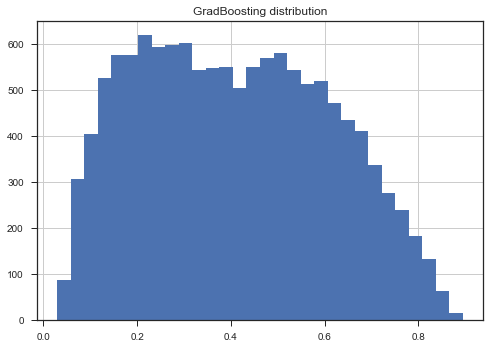

In [233]:
predict_pos = pcv.predict_proba(X_data)[:,1]
print predict_pos[0]

df_loaded_model =pd.DataFrame(predict_pos, columns=['GradBoosting distribution'])
df_loaded_model.hist(bins=30)

plt.show()

In [293]:
# Plot a mva distribution

def over_training_curve(model, mc_X, mc_y, data_X,  bins = 10):
    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()
    
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    decisions = []
    
    prob_pos = model.predict_proba(data_X)[:, 1] # [:, 1]-->[:][1]
    d1 = model.predict_proba(mc_X[mc_y>0.5])[:, 1]
    d2 = model.predict_proba(mc_X[mc_y<0.5])[:, 1]
        
    decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)  

    plt.hist([decisions[0], decisions[1]], color=['r','b'], alpha=0.5, histtype='stepfilled', 
             label=['signal','background'], bins=bins, stacked=True, normed=False)
    
    hist, bins = np.histogram(prob_pos, bins=bins, range=low_high, normed=False)
    
    scale = len(decisions) / sum(hist)
    #err = np.sqrt(hist * scale) / scale
    #err = np.sqrt(hist)
    err = np.sqrt(600)
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='black', label='data')

    plt.xlabel("Decision output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    return plt.show()

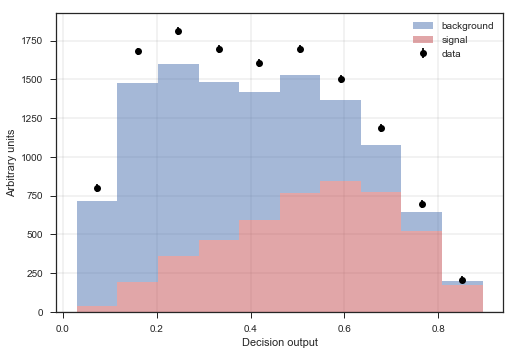

In [294]:
over_training_curve(pcv, df_X, df_y, X_data)

In [295]:
#model = pcv
#prob_pos = model.predict_proba(X_data)[:, 1] # [:, 1]-->[:][1]
#d1 = model.predict_proba(df_X[df_y>0.5])[:, 1]
#d2 = model.predict_proba(df_X[df_y<0.5])[:, 1]
        

#print np.divide(prob_pos.reshape(12878, 12878), (d1+d2).reshape(4725, 6777))

In [239]:
# http://stackoverflow.com/questions/25275800/dividing-histograms-in-pandas

def get_ratio(g):
    try:
        return float(g.shape[0]) / g.loc[g['Survived'] == 1, :].shape[0]
    except ZeroDivisionError:
        return np.nan

In [ ]:
## Features scaling, feature selection, model seleciton, hyper-parameter tuning and evaluation

process = time.time()
process = time.clock()

# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y, test_size=0.33, random_state=42)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=.33, random_state=0)

# Number of folds to partition data set
k_fold = 3 #(study suggest to use 7)

# feature scaling (robust to outliners)
scaler = RobustScaler()

# Percentile-based selection
select_percentile = SelectPercentile(score_func=f_classif, percentile=100)

# has removed the first column, which has a probability p = 5/6 > .8 
# of containing a zero.
select_variance_threshold = VarianceThreshold(threshold=0.6)

# The SelectFromModel class selects all features that have an importance measure 
# of the feature (as provided by the supervised model) greater than the provided 
# threshold.
select_select_model = SelectFromModel(RandomForestClassifier(n_estimators=10,
                                                             random_state=seed),
                                      threshold="median") #threshold=0.25

# Build a forest and compute the feature importances
select_extra_trees = ExtraTreesClassifier(random_state=0)

# feature extraction
select_kbest = SelectKBest(score_func=f_classif, k=12)

#  Recursive feature elimination (RFE-model base method)
select_rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)

# Standard K-Fold cross-validation technique
standard_kfold_cv = KFold(n_splits=k_fold, shuffle=True, random_state=seed)

# Stratified K-fold cross-validation technique
select_stratified_kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=seed)

# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('preprocessing', None), ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# select a selection method from the above list
select = select_variance_threshold

param_grid = [
    #{'classifier': [LogisticRegression()],
    # 'preprocessing': [scaler, None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [SVC()], 
    # 'preprocessing': [scaler, None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [GradientBoostingClassifier()],
    # 'preprocessing': [None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [AdaBoostClassifier()],
    # 'preprocessing': [None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [RandomForestClassifier(n_estimators=10)],
    # 'preprocessing': [None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [DecisionTreeClassifier(min_samples_leaf=10)],
    # 'preprocessing': [None],
    # 'feature_selection': [select]
    #},                                 
    #{'classifier': [GaussianNB()],
    # 'preprocessing': [scaler, None],
    # 'feature_selection': [select]
    #},
    #{'classifier': [LinearDiscriminantAnalysis()],
    # 'preprocessing': [scaler, None],
    # 'feature_selection': [select]
    #},
    {'classifier': [KNeighborsClassifier()],
     'preprocessing': [scaler, None],
     'feature_selection': [select],
     'classifier__n_neighbors': [1, 5]
    }
]

cv = standard_kfold_cv
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1) 
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Cross-validation accuracy (pipeline): {:.2f}".format(
np.mean(cross_val_score(pipe, df_X, df_y, cv=5))))
print("Pipeline steps:\n{}".format(pipe.steps))

# fit to full dataset
#grid.fit(df_X, df_y)

# Calibrated with sigmoid calibration
#sigmoid = CalibratedClassifierCV(grid, cv=3, method='sigmoid')


print "\nWall time to generate classifier models: ", time.time()-wall
print "Elapsed time to generate classifier models: ", time.clock()-process


## Test with permutations the significance of a classification score

In order to test if a classification score is significative a technique in repeating the classification procedure after randomizing, permuting, the labels. The p-value is then given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place.


In [248]:
from sklearn.model_selection import permutation_test_score

In [274]:
## Loading a dataset

n_classes = np.unique(df_y).size

# Some noisy data not correlated
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(df_X.values), 1000))

# Add noisy data to the informative features to make the task harder
#X = np.c_[X, E]
X = np.c_[df_X.values, E]

#svm = SVC(kernel='linear')
grad_model = GradientBoostingClassifier()
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
    grad_model, df_X.values, df_y.values, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=-1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.687707413678 (pvalue : 0.00990099009901)


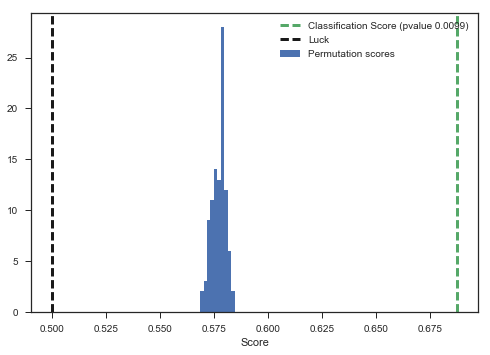

In [304]:
## View histogram of permutation scores

_=plt.hist(permutation_scores, 10, label='Permutation scores')
_=ylim = plt.ylim()

_=plt.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score (pvalue %.6s)' % pvalue)
_=plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

_=plt.ylim(ylim)
_=plt.legend(loc='upper right')
_=plt.xlabel('Score')
plt.show()

## Implementing a Weighted Majority Rule Ensemble Classifier

In order to trained a set of equally well performing models and balance out their individual weaknesses.

In [305]:
## Esemble classifier

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)]
voting='hard' #'soft'

eclf = VotingClassifier(estimators=estimators, voting=voting, weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression',
                                                 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_val_score(clf, df_X, df_y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))



Accuracy: 0.65 (+/- 0.02) [Logistic Regression]
Accuracy: 0.65 (+/- 0.02) [Random Forest]
Accuracy: 0.64 (+/- 0.03) [naive Bayes]
Accuracy: 0.66 (+/- 0.02) [Ensemble]


In [273]:
from subprocess import call
import subprocess

def visualise_tree(tree):
    """Draw the decision tree"""
    if hasattr(tree,'tree_'):
        export_graphviz(tree, out_file="tree_plot.dot", feature_names=features)
        
        !dot -Tpng -o tree_plot.png tree_plot.dot
        from IPython.display import Image
        return Image("tree_plot.png")
    else:       
        for i_tree, tree_in_forest in enumerate(tree.estimators_):
            print i_tree
            with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
                #my_file = export_graphviz(tree_in_forest, feature_names=features, out_file = my_file)
                my_file = export_graphviz(tree_in_forest, feature_names=features, out_file = my_file)
                file_out = 'tree_' + str(i_tree) + '.png'
                file_in = 'tree_' + str(i_tree) + '.dot'
                #!dot -Tpng -o file_out file_in
                #call(["dot", "-Tpng", "-o", file_out, file_in])
                subprocess.Popen("dot -Tpng -o "+" "+file_out+" "+file_in, shell=True, stdout=subprocess.PIPE).stdout.read()
                from IPython.display import Image
                #return Image('tree_' + str(i_tree) + '.png') 
                Image('tree_plot.png')
                #return Image('tree_plot.png')

In [59]:
from sklearn.tree import export_graphviz

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(df_X, df_y)

visualise_tree(dt)

#rf = RandomForestClassifier(n_estimators=1)
#rf.fit(df_X, df_y)

#visualise_tree(rf)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/bin/sh: dot: command not found


In [ ]:
def draw_decision_regions(X, y, estimator, resolution=0.01):
    """Draw samples and decision regions
    
    The true label is indicated by the colour of each
    marker. The decision tree's predicted label is
    shown by the colour of each region.
    """
    plot_step = resolution
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, axis = plot_data(X,y)
    cs = axis.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.RdBu)
    
with sns.axes_style('white'):
    draw_decision_regions(df_X.values, df_y.values, dt)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier

X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)

def plot_forest(max_depth=1):
    plt.figure()
    ax = plt.gca()
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    if max_depth != 0:
        forest = RandomForestClassifier(n_estimators=20, max_depth=max_depth,
                                        random_state=1).fit(X, y)
        Z = forest.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4)
        ax.set_title("max_depth = %d" % max_depth)
    else:
        ax.set_title("data set")
    ax.scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_forest_interactive():
    from IPython.html.widgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_forest, max_depth=slider)

In [ ]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [ ]:
visualize_tree(dt, features)

## Training a BDT with TMVA

First we will train the default Boosted Decision Tree classifier in TMVA. After this we will try and replicate this with scikit-learn.

In order to use TMVA we have to create a Factory object, to which we add the individual samples, labelling them as either "signal" or "background" and as "testing" or "training".

https://rootpy.github.io/root_numpy/auto_examples/tmva/plot_twoclass.html

In [ ]:
import ROOT as R
from ROOT import TMVA
from array import array

# ROOT and TMVA require an open file to store things
# as they go along
# Load dataset

# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y, test_size=0.50, random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=.50, random_state=seed)

In [ ]:
outfile = R.TFile('tmva_output.root', 'recreate')

factory = TMVA.Factory(tree_category, outfile, "AnalysisType=Classification")

In [ ]:
print "Step 0"
for n in range(12):
    factory.AddVariable("f%i"%n, "F")
    #print "good "

In [ ]:
print "Step 1"
for y,row in zip(y_train.values, X_train.values):
    a = R.std.vector(R.Double)()
    for r in row:
        #print r
        a.push_back(r)

    if y > 0:
        factory.AddSignalTrainingEvent(a)
    else:        
        factory.AddBackgroundTrainingEvent(a)

In [ ]:
print "Step 2"       
for y,row in zip(y_test.values, X_test.values):
    #print y, row
    a = R.std.vector(R.Double)() # instantiate a std::vector<double>
    for r in row:
        a.push_back(r)
        
    if y > 0:
        print "signal"
        factory.AddSignalTestEvent(a)
    else:
        print "background"
        factory.AddBackgroundTestEvent(a)

In [ ]:
print "Step 3"
#factory.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")
factory.PrepareTrainingAndTestTree(R.TCut("1.0"), "SplitMode=Block:SplitSeed=100:NormMode=EqualNumEvents:!V")

In [ ]:
# After adding each sample we can now set what kind of classifier 
# we would like to train as well as the hyperparameters for that classifier. 
# After that we tell TMVA to go and train the classifier.
factory.BookMethod(TMVA.Types.kBDT, "BDT", 
                   "NTrees=2:nEventsMin=1:MaxDepth=1:"
                   "BoostType=AdaBoost:AdaBoostBeta=0.5:SeparationType=GiniIndex:"
                   "nCuts=-1"
                   )

In [ ]:
print "Step 4"
factory.TrainAllMethods()

In [ ]:
print "Step 5"
reader = TMVA.Reader()

print "Step 6"
for n in range(10):
    a = array("f", [0.])
    reader.AddVariable("f%i"%n, a)
 
print "Step 7"
reader.BookMVA("BDT", "weights/classification_step7_cate4_k4001.weights.xml")

print "Step 8"
y_predicted = []
decision_val = []
for row in X_test:
    a = R.std.vector(R.Double)()
    for r in row:
        a.push_back(r)

    print "Step 9"
    value = reader.EvaluateMVA(a, "BDT")
    decision_val.append(value)
    if value > 0:
        y_predicted.append(+1)
    else:
        y_predicted.append(-1)

print "Step 10"
print classification_report(y_test, y_predicted, target_names=["background", "signal"])
print "Area under ROC curve: %.4f"%(roc_auc_score(y_test, y_predicted))

In [ ]:
D = np.array(decision_val)

print "Step 11"
plt.hist(D[y_test>0.],
         color='r', alpha=0.5, range=(-0.4,0.4), bins=30)
plt.hist(D[y_test<0.],
         color='b', alpha=0.5, range=(-0.4,0.4), bins=30)
plt.xlabel("TMVA BDT output")
plt.show()

In [4]:
import ROOT

c = ROOT.TCanvas("c")
h = ROOT.TH1F("h","ROOT Histo;X;Y",64,-4,4)

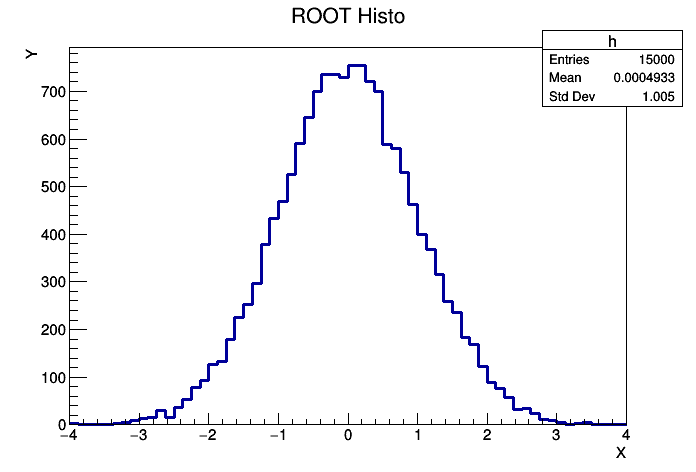

In [8]:
%%cpp
h->FillRandom("gaus");
h->Draw();
c->Draw();

In [ ]:
## Feature ranking study

#process = time.time()
#process = time.clock()

# Univariate Statistics
#select = VarianceThreshold(threshold=(.8 * (1 - .8)))

# Features selected by variance threshold
#_= select.fit_transform(df_X);

#importances = select.variances_
#indices = np.argsort(importances)[::-1]

#feature_ranking_plot(df_X, indices, "Feature importances based on variance ranking")

# The SelectFromModel class selects all features that have an importance measure 
# of the feature (as provided by the supervised model) greater than the provided 
# threshold.
#select_model = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=seed), 
#                         threshold="median") #threshold=0.25

# Features selected by SelectFromModel using the RandomForestClassifier
#_= select_model.fit_transform(df_X, df_y)

#importances = select_model.estimator_.feature_importances_
#std = np.std([tree.feature_importances_ for tree in select_model.estimator_], axis=0)
#indices = np.argsort(importances)[::-1]

#feature_ranking_plot(df_X, indices, "Model-based feature importances ranking")

# Build a forest and compute the feature importances
#extra_forest = ExtraTreesClassifier(random_state=0)
#select_model = SelectFromModel(extra_forest, threshold="median")
#_= select_model.fit(df_X, df_y)

#importances = select_model.estimator_.feature_importances_
#std = np.std([tree.feature_importances_ for tree in select_model.estimator_], axis=0)
#indices = np.argsort(importances)[::-1]

#feature_ranking_plot(df_X, indices, "Feature importances based on Extra-Tree classification ranking")

# Univariate Statistics
# Features selected k-highest scores
#score_func=f_classif, k=6
#select = SelectKBest(score_func=f_classif, k=12)

#_= select.fit_transform(df_X);

#importances = select.importances_
#indices = np.argsort(importances)[::-1]

#feature_ranking_plot(df_X, indices, "Feature importances based on variance ranking")

#  Recursive feature elimination (RFE-model base method)
#rfe = RFE(estimator=AdaBoostClassifier(), n_features_to_select=11, step=1) #n_features_to_select=8  
#_= rfe.fit(df_X, df_y)

#importances = rfe.ranking_
#indices = np.argsort(importances)[::-1]

#feature_ranking_plot(df_X, indices,"Feature importances based on RFE model ranking")

#print "Wall time to produce feature ranking plots: ", time.time()-wall
#print "Elapsed time to prodduce feature ranking plots: ", time.clock()-process